# Trabajo Practico 1 - Analisis de Series Temporales

## Importacion de Librerias

In [119]:
import pandas as pd

import numpy as np

import math

import seaborn as sns

import scipy.stats
from scipy import stats

import pylab

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error
from arch.unitroot import PhillipsPerron

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
tema_azul = ['#0000CC','#3366FF','#99CCFF']
tema_rojo = ['#CC0000','#FF3333','#FF9999']
tema_verde = ['#009900','#33AA33','#55BB55']
tema_negro = ['#000000','#333333','#555555']

## Definicion de Funciones

### Trabajo de Datos

In [5]:
def filtrar_serie(serie, start_date, end_date):
    serie = serie[(serie.index >= start_date) & (serie.index <= end_date)]
    return serie

In [6]:
def corregir_usd_ipc(serie, ipc, dolar):
    corregida = serie / (1 + ipc)
    corregida = corregida / dolar
    return corregida

### Graficas

In [7]:
def autocov_autocorr(s1,s2, numlag= 20, color = ['#000000','#333333','#555555']):
  p1, axes = plt.subplots(3,2,figsize=(14,9), sharex=True, sharey=False )

  axes[2,0].set_xlabel('Lags', fontsize=8)
  axes[2,1].set_xlabel('Lags', fontsize=8)
  
  axes[0,0].set_ylabel('FAC', fontsize=8)
  axes[1,0].set_ylabel('FACP', fontsize=8)
  axes[2,0].set_ylabel('FAS', fontsize=8)

  #grafico correlacion
  plot_acf(s1, lags=numlag, ax= axes[0,0], color=color[0], label="ACF", vlines_kwargs={"colors":color[0]})
  axes[0,0].set_title(label = s1.name, fontsize=9)
  axes[0,0].tick_params(axis='both', labelsize=7)
  for item in axes[0,0].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')

  plot_acf(s2, lags=numlag, ax= axes[0,1], color=color[0], label="ACF", vlines_kwargs={"colors":color[0]}, title=s2.name)
  axes[0,1].set_title(label = s2.name, fontsize=9)
  axes[0,1].tick_params(axis='both', labelsize=7)
  for item in axes[0,1].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')
  
  #grafico correlacion parcial
  plot_pacf(s1, lags=numlag, ax= axes[1,0], color=color[1], label="PACF", vlines_kwargs={"colors":color[1]}, title='', method='ywm')
  axes[1,0].tick_params(axis='both', labelsize=7)
  for item in axes[1,0].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')

  plot_pacf(s2, lags=numlag, ax= axes[1,1], color=color[1], label="PACF", vlines_kwargs={"colors":color[2]}, title='', method='ywm')
  axes[1,1].tick_params(axis='both', labelsize=7)
  for item in axes[1,1].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')


  #grafico covarianza
  axes[2,0].plot(tsa.acovf(s1,fft=False, nlag=numlag), color=color[2], label='AutoCov')
  axes[2,0].tick_params(axis='both', labelsize=7)
  axes[2,1].plot(tsa.acovf(s2,fft=False, nlag=numlag), color=color[2], label='AutoCov')
  axes[2,1].tick_params(axis='both', labelsize=7)

  #p1.legend()
  plt.show()
#autocov_autocorr(df.ventas_ajustado, df.diff1, 20, tema_rojo)

In [8]:
def prueba_residuos(resid, color = ['#000000','#333333','#555555']):
    p1, axes = plt.subplots(3,2,figsize=(15,10))
    #p1, axes = plt.subplot_mosaic('AB;CD;EF;GG')

    plot_acf(resid, ax= axes[0,0], color=color[0], vlines_kwargs={"colors":color[0]})
    axes[0,0].set_title(label = 'Autocorrelacion', fontsize=10)
    axes[0,0].tick_params(axis='both', labelsize=7)
    axes[0,0].get_lines()[1].set(markersize = 5.0, markerfacecolor = color[1], markeredgecolor = color[2])
    for item in axes[0,0].collections:
        #change the color of the CI 
        if type(item)==PolyCollection:
            item.set_facecolor('#AAAAAA')

    #plot_pacf(resid, ax= axes[0,1]);
    plot_pacf(resid, ax= axes[0,1], color=color[0], vlines_kwargs={"colors":color[0]})
    axes[0,1].set_title(label = 'Autocorrelacion Parcial', fontsize=10)
    axes[0,1].tick_params(axis='both', labelsize=7)
    axes[0,1].get_lines()[1].set(markersize = 5.0, markerfacecolor = color[1], markeredgecolor = color[2])
    for item in axes[0,1].collections:
        #change the color of the CI 
        if type(item)==PolyCollection:
            item.set_facecolor('#AAAAAA')

    axes[1,0].plot(resid, color = color[1])
    axes[1,0].set_title("Residuos del modelo",size=10)
    axes[1,0].tick_params(axis='both', labelsize=7)

    sns.distplot(resid,bins=12,color=color[1], ax=axes[1,1])
    axes[1,1].set_title(f'Histograma de residuos - Shapiro p-value = {stats.shapiro(resid).pvalue:.4f}',size=10)

    scipy.stats.probplot(resid, plot = axes[2,0])
    axes[2,0].set_title("QQ Plot", size = 10)
    axes[2,0].get_lines()[0].set(markersize = 3.0, markerfacecolor = color[1], markeredgecolor = color[2], color = color[1])
    axes[2,0].get_lines()[1].set(color = color[1])
    axes[2,0].tick_params(axis='both', labelsize=7)

    Incorr_residuos_modelo=sm.stats.acorr_ljungbox(resid, lags=10)
    axes[2,1].plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
    axes[2,1].set_title("Grafico de incorrelacion de los residuos del modelo", size = 10)
    axes[2,1].set_ylabel("P-valores ")
    axes[2,1].get_lines()[0].set(markersize = 10.0, markerfacecolor = color[1], markeredgecolor = color[2], color = color[1])
    axes[2,1].tick_params(axis='both', labelsize=7)

#prueba_residuos(modelo_sarima.resid, tema_verde)

In [9]:
def graficar_pred(train, test, pred, confint, xlabel="Fecha", ylabel="ARS$", color = ['#000000','#333333','#555555']):
    p1, axes = plt.subplot_mosaic('AB;CC',figsize=(15,10))

    axes['A'].plot(train, color = color[0])
    axes['A'].set_xlabel(xlabel)
    axes['A'].set_ylabel(ylabel)
    axes['A'].set_title('Serie Original')
    axes['A'].grid(True, color='0.6', dashes=(5,2,1,2))

    axes['B'].plot(confint.iloc[:,1],label="", color='#222222')
    axes['B'].plot(confint.iloc[:,0],label="", color='#222222')
    axes['B'].plot(test, label="Valores Observados", color = color[0])
    axes['B'].plot(pred, label="Predicciones", color = color[2])
    axes['B'].fill_between(pred.index, confint.iloc[:,1], confint.iloc[:,0], facecolor=color[2], alpha=0.3)
    axes['B'].fill_between(pred.index, pred, test, facecolor=color[1], alpha=0.6)
    axes['B'].set_xlabel(xlabel)
    axes['B'].set_ylabel(ylabel)
    axes['B'].set_title('Predicciones - Intervalo de Confianza')
    axes['B'].legend(loc=0)
    axes['B'].grid(True, color='0.6', dashes=(5,2,1,2))

    axes['C'].plot(train, color = color[0])
    axes['C'].plot(test, color = color[1])
    axes['C'].plot(pred, color = color[2])
    axes['C'].set_xlabel(xlabel)
    axes['C'].set_ylabel(ylabel)
    axes['C'].set_title('Valores Reales vs Observados')
    axes['C'].fill_between(pred.index, pred, test, facecolor=color[1], alpha=0.8)
    axes['C'].fill_between(pred.index, confint.iloc[:,1], confint.iloc[:,0], facecolor=color[2], alpha=0.3)
    axes['C'].grid(True, color='0.6', dashes=(5,2,1,2))

#graficar_pred(train, test[:16], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int(), color = tema_azul)

### Tests Estadisticos

In [10]:
def print_test_adf(y):
  print("_".center(120, '_'))
  print(f'Augmented Dickey-Fuller')
  print(f'Estadistico ADF\t\tp-Valor\tEstacionaridad\tModo')
  resultado = adfuller(y, regression='c')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tConstante sola')

  resultado = adfuller(y, regression='ct')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tConstante y Tendencia Lineal')

  resultado = adfuller(y, regression='ctt')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tConstante y Tendencia Lineal y Cuadratica')

  resultado = adfuller(y, regression='n')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tSin Contante ni Tendencia')
  print("_".center(120, '_'))
#print_test_adf(df.ventas_ajustado)
#print_test_adf(df.diff1)

In [11]:
def Phillips_Perron(series, **k):

    params = {'n':'No incluye término independiente ni lineal',
              'c':'Con término independiente, Sin término lineal',
              'ct':'Incluye ambos términos'
              }
    print("_".center(120, '_'))
    print(f'Phillips-Perron')
    print(f'Estadistico PP\tp-Valor\t\tNumLags\t\tEstacionaridad\tnDiffs\tTipo_Regresion')
    for param in params:
        pp = PhillipsPerron(series,trend=param, **k)
        print(f"{pp.stat:.2f}\t\t{pp.pvalue:.4f}\t\t{pp.lags}\t\t{'No' if pp.pvalue > 0.05 else 'Si'}\t\t{ndiffs(series, test='pp')}\t{param}-{params.get(param)}")
    print("_".center(120, '_'))

#Phillips_Perron(df.ventas_ajustado)
#Phillips_Perron(df.diff1)

In [12]:
def kpss_test(series, **kw):

    params = {'c':'estacionarios alrededor de una constante.',
              'ct': 'estacionarios alrededor de una tendencia.'
             }
    print("_".center(120, '_'))
    print(f'KPSS')
    print(f'Estad. KPSS\tp-Valor\t\tNumLags\t\tEstacionaridad\tnDiffs\tTipo_Regresion')
    
    for param in params:
        statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)
        print(f"{statistic:.4f}\t\t{p_value:.4f}\t\t{n_lags}\t\t{'No' if p_value < 0.05 else 'Si'}\t\t{ndiffs(series, test='kpss')}\t{param} - {params.get(param)}")
    print("_".center(120, '_'))
#kpss_test(df.ventas_ajustado)

In [13]:
def medidas_error(serie_test, serie_pred):
    MSE = mean_squared_error(serie_test, serie_pred)
    MAE = mean_absolute_error(serie_test, serie_pred)
    RMSE = np.sqrt(mean_squared_error(serie_test, serie_pred))
    MAPE = np.mean(abs((serie_test-serie_pred)/serie_test))

    return MSE, MAE, RMSE, MAPE
#evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

In [14]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE:\t{mean_squared_error(serie_test, serie_pred):.0f}')
    print(f'MAE:\t{mean_absolute_error(serie_test, serie_pred):.0f}')
    print(f'RMSE:\t{np.sqrt(mean_squared_error(serie_test, serie_pred)):.0f}')
    print(f'MAPE:\t{round(np.mean(abs((serie_test-serie_pred)/serie_test)),4):.3f}')

#evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

In [15]:
def grangers_causation_matrix(data, variables, maxlag, testgr='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [(test_result[i+1][0][testgr][1],i+1) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#grangers_causation_matrix(train2, variables = train2.columns, maxlag=5, verbose=False)

In [16]:
def highlight_min(s):
    is_min = s == s.min()
    return [f'background-color: green' if v else '' for v in is_min]

In [17]:
def calcular_errores(test_serie, modelos_alt_nombres, modelos_alt, per = 16):
    df_errores = pd.DataFrame()
    df_errores['Modelo'] = modelos_alt_nombres
    df_errores['Akaike'] = [m.aic for m in modelos_alt]

    i, MSE, MAE, RMSE, MAPE = 0, [], [], [], []
    for m in modelos_alt:
        pred_m = m.get_forecast(per)
        m_MSE, m_MAE, m_RMSE, m_MAPE = medidas_error(test_serie[:per], pred_m.predicted_mean )
        MSE = np.append(MSE, m_MSE)
        MAE = np.append(MAE, m_MAE)
        RMSE = np.append(RMSE, m_RMSE)
        MAPE = np.append(MAPE, m_MAPE)

    df_errores['MSE'] = MSE
    df_errores['MAE'] = MAE
    df_errores['RMSE'] = RMSE
    df_errores['MAPE'] = MAPE
    
    df_errores.style.apply(highlight_min, subset=['Akaike', 'MSE', 'MAE','RMSE','MAPE'])\
        .format({'Akaike': "{:.0f}",'MSE': "{:.2E}",'MAE': "{:.2E}",'RMSE': "{:.2E}",'MAPE': "{:.0%}"})
    
    return df_errores

#df_err = calcular_errores(test, modelos_alt_nombres, modelos_alt, 10)


## Importacion y Trabajo de Datos

In [18]:
vent_full = pd.read_excel('.\Data\Descarga_VENTAS_POR_LOCALES_NB_050923.xlsx',skiprows=1)
df_vent = vent_full.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_vent.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_vent.mes = pd.to_datetime(df_vent.mes, dayfirst = True, format = '%m/%Y')
df_vent = df_vent.sort_values(by = 'mes')
df_vent.set_index('mes', inplace = True)
df_vent.head()

,ventas
mes,
2015-01-01,62633592.89
2015-02-01,62563213.35
2015-03-01,70487376.77
2015-04-01,68644186.80
2015-05-01,70835132.46


In [19]:
df_ipc = pd.read_excel('.\Data\Tabla_IPC.xlsx',skiprows=1)
df_ipc.rename(columns={'Fecha': 'fecha', 'Indice': 'ipc'}, inplace = True)
df_ipc.set_index('fecha', inplace=True)
df_ipc['ipc_previo'] = df_ipc['ipc'].shift(1)
df_ipc['ipc_intermensual'] = (df_ipc['ipc'] - df_ipc['ipc_previo']) / df_ipc['ipc']
df_ipc.head()

,ipc,ipc_previo,ipc_intermensual
fecha,,,
2016-12-01,100.0000,NaN,NaN
2017-01-01,101.5859,100.0000,0.015611
2017-02-01,103.6859,101.5859,0.020253
2017-03-01,106.1476,103.6859,0.023191
2017-04-01,108.9667,106.1476,0.025871


In [20]:
df_usd = pd.read_excel('.\Data\Dolar_Evolución.xlsx',skiprows=0)
df_usd = df_usd.iloc[:, 1:]
df_usd.columns = ['fecha', 'ofi', 'blue']
df_usd.set_index('fecha', inplace=True)
df_usd.head()

,ofi,blue
fecha,,
2015-01-01,8.55,13.50
2015-02-01,8.63,12.93
2015-03-01,8.72,12.52
2015-04-01,8.81,12.60
2015-05-01,8.90,12.55


In [21]:
df_retail = vent_full[(vent_full['Razón Social'] != 'GD WORK SA') & (vent_full['Rubro'] != 'SUPERMERCADO')]
df_retail = df_retail.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_retail.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_retail.mes = pd.to_datetime(df_retail.mes, dayfirst = True, format = '%m/%Y')
df_retail = df_retail.sort_values(by = 'mes')
df_retail.set_index('mes', inplace = True)
df_retail.head()

,ventas
mes,
2015-01-01,35881254.22
2015-02-01,35994300.23
2015-03-01,41635908.20
2015-04-01,41074614.00
2015-05-01,43747283.60


In [22]:
df_super = vent_full[vent_full['Rubro'] == 'SUPERMERCADO']
df_super = df_super.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_super.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_super.mes = pd.to_datetime(df_super.mes, dayfirst = True, format = '%m/%Y')
df_super = df_super.sort_values(by = 'mes')
df_super.set_index('mes', inplace = True)
df_super.head()

,ventas
mes,
2015-01-01,26752338.67
2015-02-01,26568913.12
2015-03-01,28851468.57
2015-04-01,27569572.80
2015-05-01,27087848.86


In [23]:
df_cowork = vent_full[vent_full['Razón Social'] == 'GD WORK SA']
df_cowork = df_cowork.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_cowork.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_cowork.mes = pd.to_datetime(df_cowork.mes, dayfirst = True, format = '%m/%Y')
df_cowork = df_cowork.sort_values(by = 'mes')
df_cowork.set_index('mes', inplace = True)
df_cowork.head()

,ventas
mes,
2019-01-01,824754.21
2019-02-01,983820.43
2019-03-01,1281202.80
2019-04-01,2000058.99
2019-05-01,1787994.13


In [24]:
df_vent = filtrar_serie(df_vent, '2017-01-01', '2023-08-01')
df_retail = filtrar_serie(df_retail, '2017-01-01', '2023-08-01')
df_cowork = filtrar_serie(df_cowork, '2017-01-01', '2023-08-01')
df_super = filtrar_serie(df_super, '2017-01-01', '2023-08-01')
df_usd = filtrar_serie(df_usd, '2017-01-01', '2023-08-01')

df_vent['ventas_ajustado'] = corregir_usd_ipc(df_vent['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_cowork['ventas_ajustado'] = corregir_usd_ipc(df_cowork['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_retail['ventas_ajustado'] = corregir_usd_ipc(df_retail['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_super['ventas_ajustado'] = corregir_usd_ipc(df_super['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])

df_vent['diff1'] = df_vent.ventas_ajustado.diff(periods = 1)
df_vent.diff1[0] = 0

df_cowork['diff1'] = df_cowork.ventas_ajustado.diff(periods = 1)
df_cowork.diff1[0] = 0

df_retail['diff1'] = df_retail.ventas_ajustado.diff(periods = 1)
df_retail.diff1[0] = 0

df_super['diff1'] = df_super.ventas_ajustado.diff(periods = 1)
df_super.diff1[0] = 0

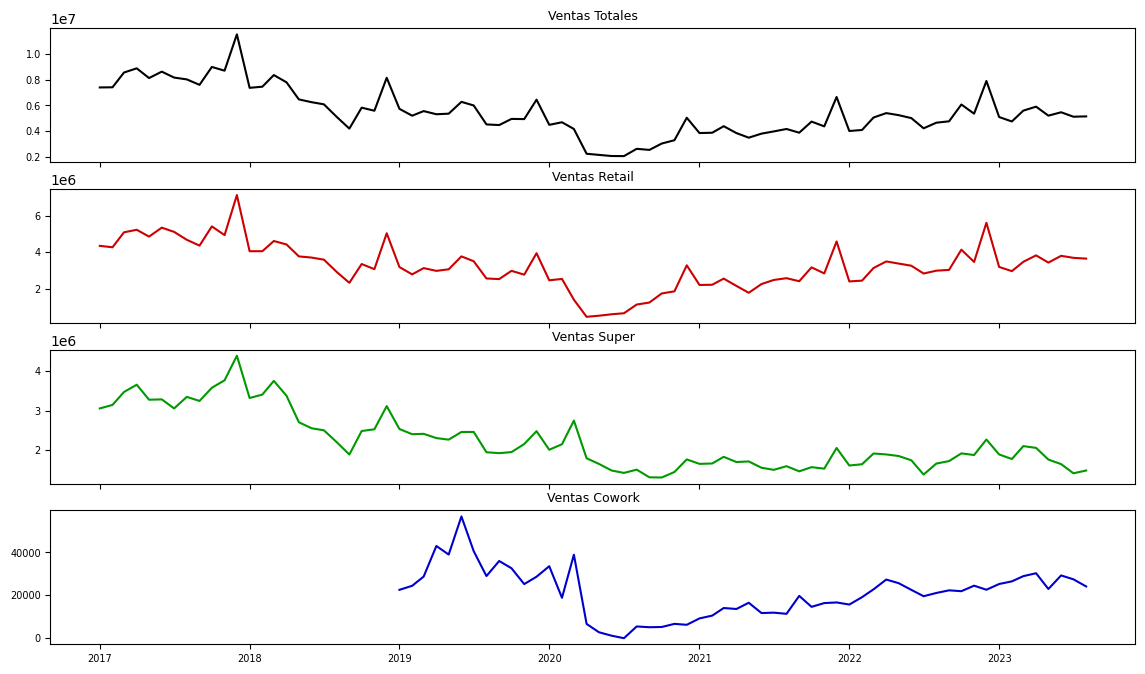

In [25]:
p1, axes = plt.subplots(4,1,figsize=(14,8), sharex=True, sharey=False )
#axes[0].df_vent.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Total", color='black')
#axes[0].df_cowork.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Cowork", color='red')
#axes[0].df_retail.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Retail", color='green')
axes[0].plot(df_vent.ventas_ajustado, color=tema_negro[0])
axes[0].set_title(label = 'Ventas Totales', fontsize=9)
axes[0].tick_params(axis='both', labelsize=7)

axes[1].plot(df_retail.ventas_ajustado, color=tema_rojo[0])
axes[1].set_title(label = 'Ventas Retail', fontsize=9)
axes[1].tick_params(axis='both', labelsize=7)

axes[2].plot(df_super.ventas_ajustado, color=tema_verde[0])
axes[2].set_title(label = 'Ventas Super', fontsize=9)
axes[2].tick_params(axis='both', labelsize=7)

axes[3].plot(df_cowork.ventas_ajustado, color=tema_azul[0])
axes[3].set_title(label = 'Ventas Cowork', fontsize=9)
axes[3].tick_params(axis='both', labelsize=7)


# Analisis de Series

## Serie Retail

### Inciso 2 -  Grafico de la serie original

In [26]:
df = df_retail
#df['diff1'] = df.ventas_ajustado.diff(periods = 1)
#df.diff1[0] = 0
tema = tema_rojo
nombre_serie = 'Ventas Retail'

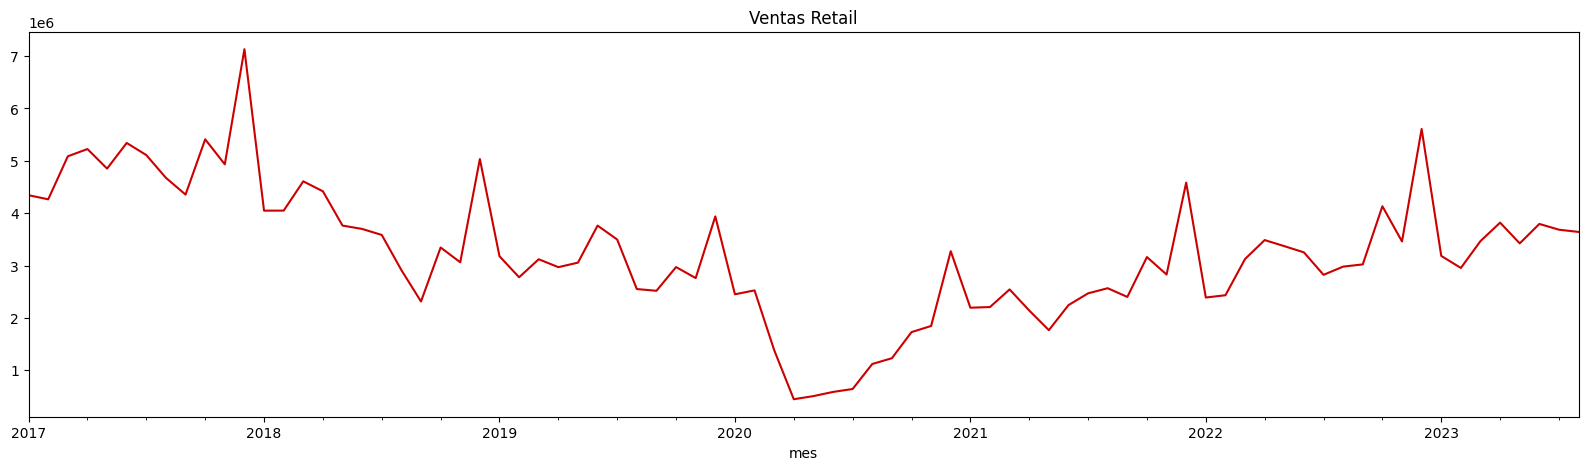

In [27]:
df.ventas_ajustado.plot(figsize=(20,5), title = nombre_serie, color = tema[0])
plt.show()

a simple vista no es estacionaria

### Inciso 3 - Funciones de ACF y PACF

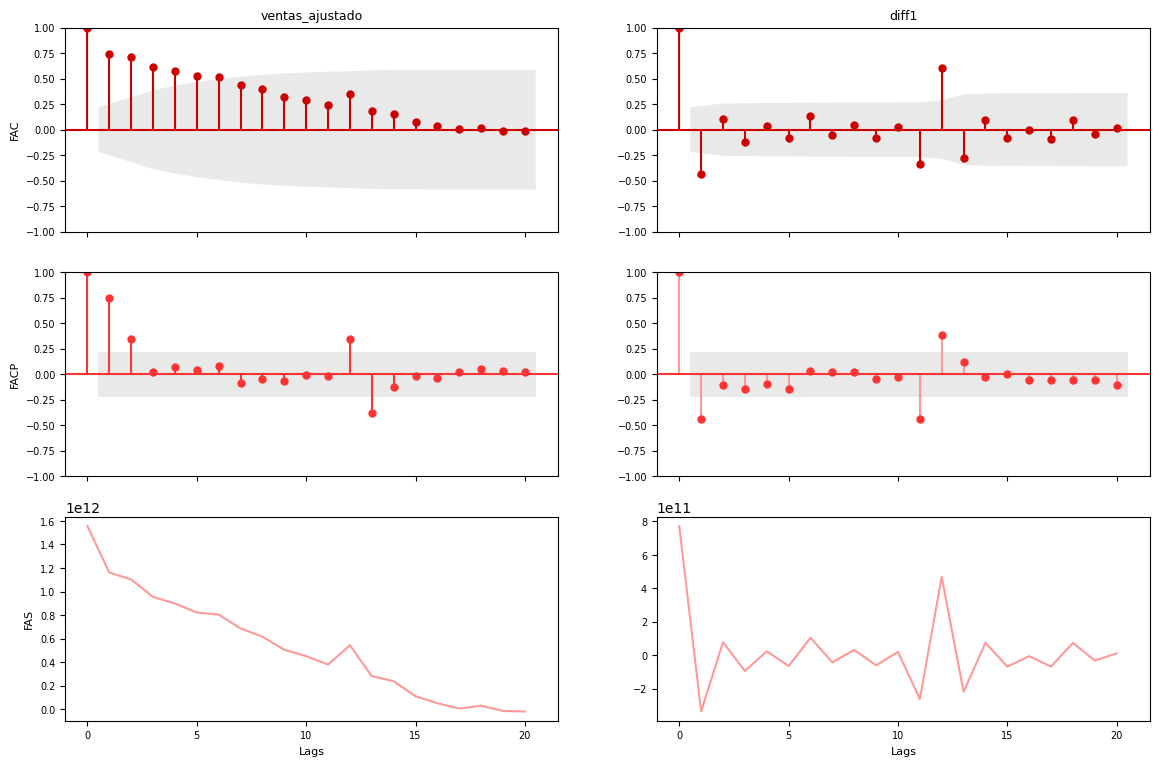

In [28]:
autocov_autocorr(df.ventas_ajustado, df.diff1, 20, tema)

### Inciso 4 - Pruebas de raices unitarias

In [29]:
print_test_adf(df.ventas_ajustado)
Phillips_Perron(df.ventas_ajustado)
kpss_test(df.ventas_ajustado)

________________________________________________________________________________________________________________________
Augmented Dickey-Fuller
Estadistico ADF		p-Valor	Estacionaridad	Modo
-2.1134 		0.2391 	No 		Constante sola
-1.5532 		0.8102 	No 		Constante y Tendencia Lineal
-2.7274 		0.4387 	No 		Constante y Tendencia Lineal y Cuadratica
-0.7234 		0.4027 	No 		Sin Contante ni Tendencia
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
Phillips-Perron
Estadistico PP	p-Valor		NumLags		Estacionaridad	nDiffs	Tipo_Regresion
-0.87		0.3400		12		No		1	n-No incluye término independiente ni lineal
-3.62		0.0055		12		Si		1	c-Con término independiente, Sin término lineal
-3.96		0.0100		12		Si		1	ct-Incluye ambos términos
____________________________________________________________________________________

Hasta ahora comprobamos que la serie original no es estacionaria

Pero los tests nos dan indicios de que la primer diferencia podria funcionar

arIma para todos

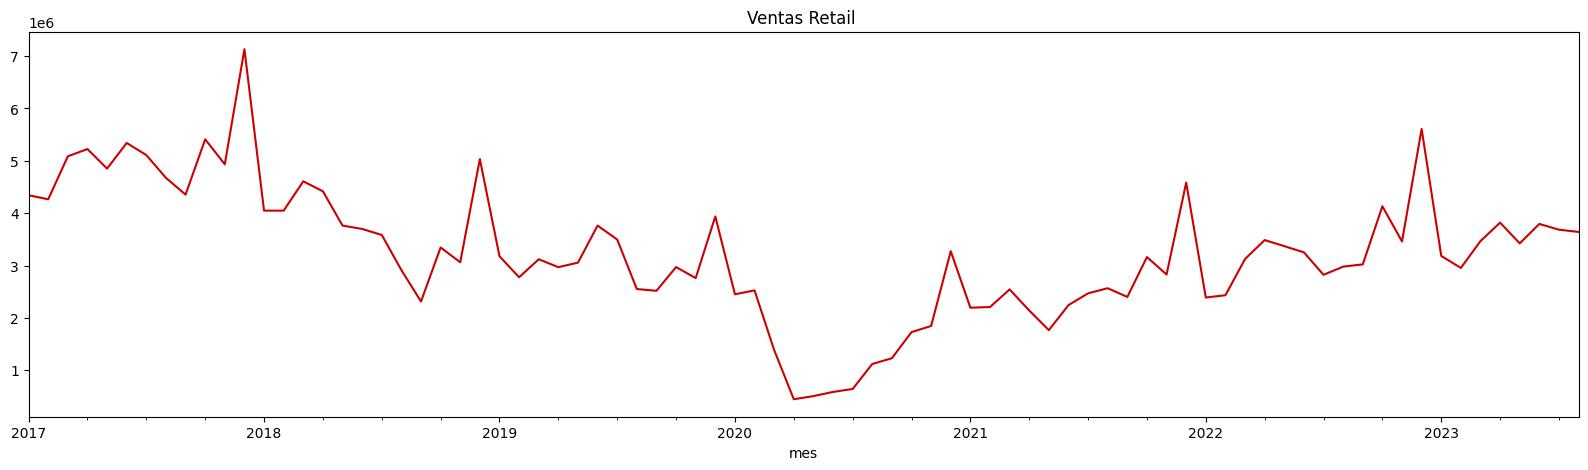

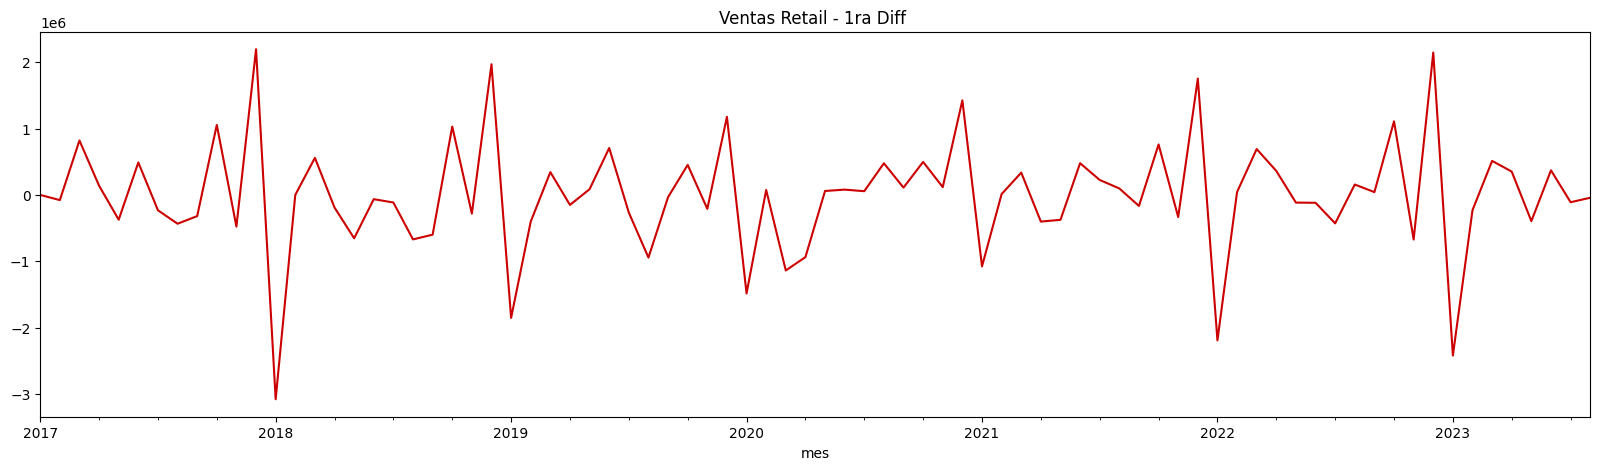

________________________________________________________________________________________________________________________
Augmented Dickey-Fuller
Estadistico ADF		p-Valor	Estacionaridad	Modo
-2.7607 		0.0641 	No 		Constante sola
-4.3799 		0.0024 	Si		Constante y Tendencia Lineal
-4.0866 		0.0245 	Si		Constante y Tendencia Lineal y Cuadratica
-2.6607 		0.0076 	Si		Sin Contante ni Tendencia
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
Phillips-Perron
Estadistico PP	p-Valor		NumLags		Estacionaridad	nDiffs	Tipo_Regresion
-18.04		0.0000		12		Si		0	n-No incluye término independiente ni lineal
-17.99		0.0000		12		Si		0	c-Con término independiente, Sin término lineal
-19.16		0.0000		12		Si		0	ct-Incluye ambos términos
____________________________________________________________________________________

In [30]:
df.ventas_ajustado.plot(figsize=(20,5), title = f"{nombre_serie} ", color = tema[0])
plt.show()

df.diff1.plot(figsize=(20,5), title = f"{nombre_serie} - 1ra Diff ", color = tema[0])
plt.show()
print_test_adf(df.diff1)
Phillips_Perron(df.diff1)
kpss_test(df.diff1)


### Inciso 5 - SARIMAX

In [31]:
sarimax = auto_arima(df.ventas_ajustado,
                     start_p=1, max_p=12,
                     start_d=1, max_d=3,
                     start_q=1, max_q=12,
                     start_P=0, max_P=12,
                     start_D=0, max_D=12,
                     start_Q=0, max_Q=12,
           seasonal=True, m=12, trace=True, stepwise=True, information_criterion='aic')
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2383.102, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2391.582, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2376.702, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2378.544, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2389.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2380.998, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2378.115, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2377.113, Time=0.26 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2377.577, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2379.077, Time=0.53 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2382.804, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2378.722, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2378.813, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2377.678, Time=0.17 sec
 ARIMA(2,1,1)(1,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   80
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -1184.329
Date:                            Wed, 15 Nov 2023   AIC                           2374.658
Time:                                    03:33:32   BIC                           2381.766
Sample:                                01-01-2017   HQIC                          2377.505
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2898      0.064     -4.560      0.000      -0.414      -0.165
ar.S.L12       0.2599      0.050      5.210      0.000       0.162       0.358
sigma2      6.422e+11   1.57e-14    4.1e+25      0.000    6.42e+11    6.42e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):                71.02
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.79
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

### Inciso 6 - Predecir

In [32]:
# Separacion Train/Test
train = df.iloc[:round(len(df)*.80)].ventas_ajustado
test = df.iloc[round(len(df)*.80):].ventas_ajustado

In [33]:
modelo_sarima = SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,0,12))
modelo_sarima = modelo_sarima.fit()
print(modelo_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    ventas_ajustado   No. Observations:                   64
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -946.511
Date:                            Wed, 15 Nov 2023   AIC                           1899.022
Time:                                    03:33:32   BIC                           1905.452
Sample:                                01-01-2017   HQIC                          1901.551
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.075     -3.627      0.000      -0.422      -0.126
ar.S.L12       0.1545      0.056   

### Inciso 7 - Probar otros modelos

In [34]:
modelos_alt = []
modelos_alt.append(SARIMAX(train, order=(1,0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,0,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,1,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,1,12)).fit())

modelos_alt.append(SARIMAX(train, order=((1,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,0), seasonal_order=(1,0,0,12)).fit())

modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())

modelos_alt_nombres = ['AR 1','MA 1','ARMA 1-1','AR 1,2','MA 1,2','AR 1,2,12','MA 1,2,12',
                       'ARIMA 1-1-0','ARIMA 0-1-1','ARIMA 1-1-1','ARIMA 1,2-1-0','ARIMA 0-1-1,2','ARIMA 1,2,12-1-0','ARIMA 0-1-1,2,12',
                       'SARIMA 1-1-0 Season AR 1','SARIMA 1-1-0 Season MA 1','SARIMA 1-1-0 Season ARMA 1-1',
                       'AR 1,12','ARIMA 1,12-1-0',
                       'MA 1,12','ARIMA 0-1-1,12',
                       'ARIMA 0-0-0 Season AR 1',
                       'AR 12','MA 12','ARIMA 12-1-0','ARIMA 0-1-12']

i = 0
for mod in modelos_alt:
    print(f'Modelo {i}-Akaike: {round(mod.aic,4)}-\t{modelos_alt_nombres[i]}')
    i += 1

Modelo 0-Akaike: 1939.3972-	AR 1
Modelo 1-Akaike: 2072.397-	MA 1
Modelo 2-Akaike: 1929.4622-	ARMA 1-1
Modelo 3-Akaike: 1930.729-	AR 1,2
Modelo 4-Akaike: 2057.2077-	MA 1,2
Modelo 5-Akaike: 8.0-	AR 1,2,12
Modelo 6-Akaike: 2028.2274-	MA 1,2,12
Modelo 7-Akaike: 1898.9437-	ARIMA 1-1-0
Modelo 8-Akaike: 1899.373-	ARIMA 0-1-1
Modelo 9-Akaike: 1900.9254-	ARIMA 1-1-1
Modelo 10-Akaike: 1900.967-	ARIMA 1,2-1-0
Modelo 11-Akaike: 1901.1304-	ARIMA 0-1-1,2
Modelo 12-Akaike: 51.0803-	ARIMA 1,2,12-1-0
Modelo 13-Akaike: 1902.9348-	ARIMA 0-1-1,2,12
Modelo 14-Akaike: 1899.0221-	SARIMA 1-1-0 Season AR 1
Modelo 15-Akaike: 1899.1972-	SARIMA 1-1-0 Season MA 1
Modelo 16-Akaike: 1900.5622-	SARIMA 1-1-0 Season ARMA 1-1
Modelo 17-Akaike: 6.0-	AR 1,12
Modelo 18-Akaike: 1938.6846-	ARIMA 1,12-1-0
Modelo 19-Akaike: 2045.4012-	MA 1,12
Modelo 20-Akaike: 1900.9043-	ARIMA 0-1-1,12
Modelo 21-Akaike: 2025.9619-	ARIMA 0-0-0 Season AR 1
Modelo 22-Akaike: 2025.9619-	AR 12
Modelo 23-Akaike: 2078.8583-	MA 12
Modelo 24-Akaike: 19

In [35]:
modelo_pick = modelos_alt[25]
print(modelo_pick.summary())


                                SARIMAX Results                                
Dep. Variable:         ventas_ajustado   No. Observations:                   64
Model:             SARIMAX(0, 1, [12])   Log Likelihood                -950.372
Date:                 Wed, 15 Nov 2023   AIC                           1904.744
Time:                         03:33:41   BIC                           1909.030
Sample:                     01-01-2017   HQIC                          1906.429
                          - 04-01-2022                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L12         0.2075      0.038      5.518      0.000       0.134       0.281
sigma2      6.077e+11    2.4e-14   2.54e+25      0.000    6.08e+11    6.08e+11
Ljung-Box (L1) (Q):                   9.31  

Dados los resultados finales de los tests, principalmente el AIC porque es facil de evaluar a simple vista

Concluimos que el mejor modelo es el que propuso AutoARIMA (Un ARIMA 1-1-0 con Season AR 1 (12))

### Inciso 8 - Analisis de Diagnostico

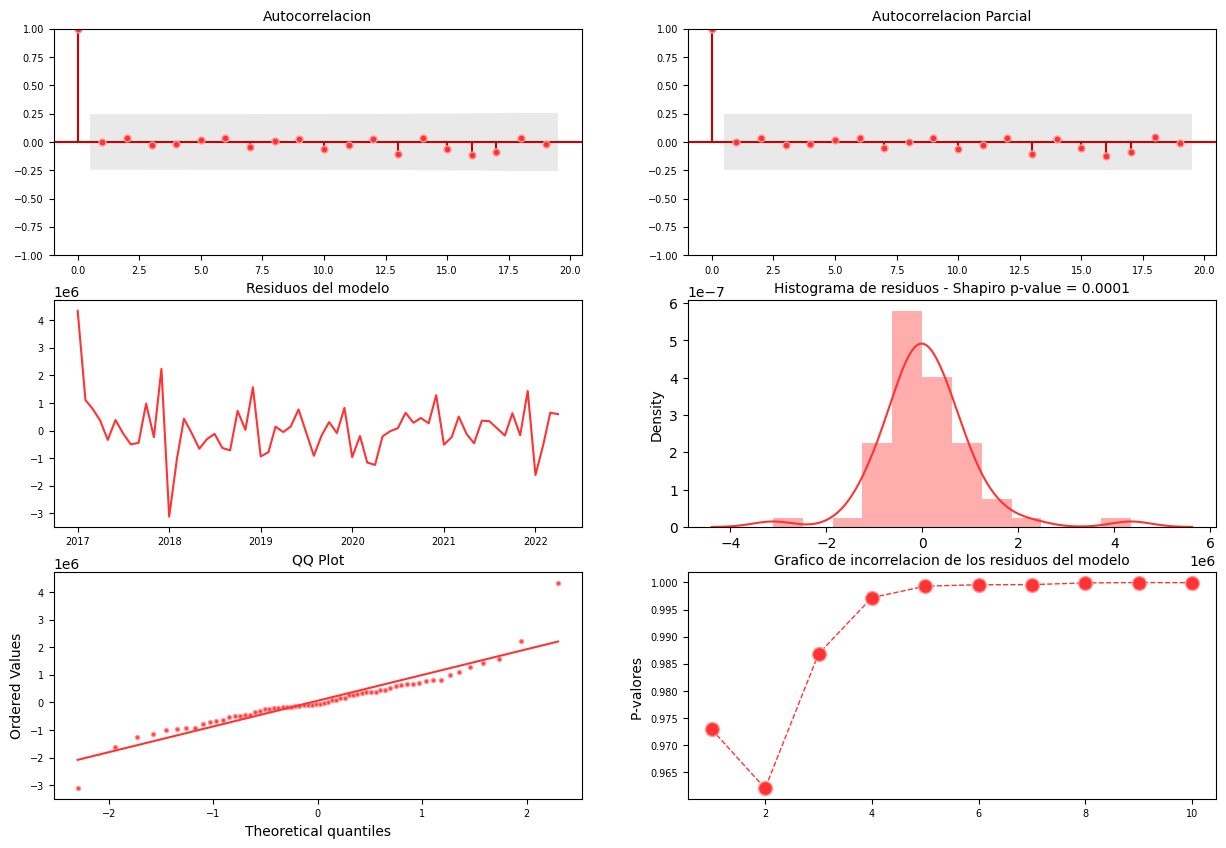

In [36]:
prueba_residuos(modelo_sarima.resid, color = tema)

La hipotesis nula es que los datos son independientes
vemos que generalmente no rechazan

aprueba el test

notamos que los residuos son ruido blanco, lo cual es favorable

pero que su distribucion no es normal, lo que reduce la validez del modelo para efectuar predicciones

### Inciso 9 - Pronosticar

In [37]:
predicciones_sarima = modelo_sarima.get_forecast(16)

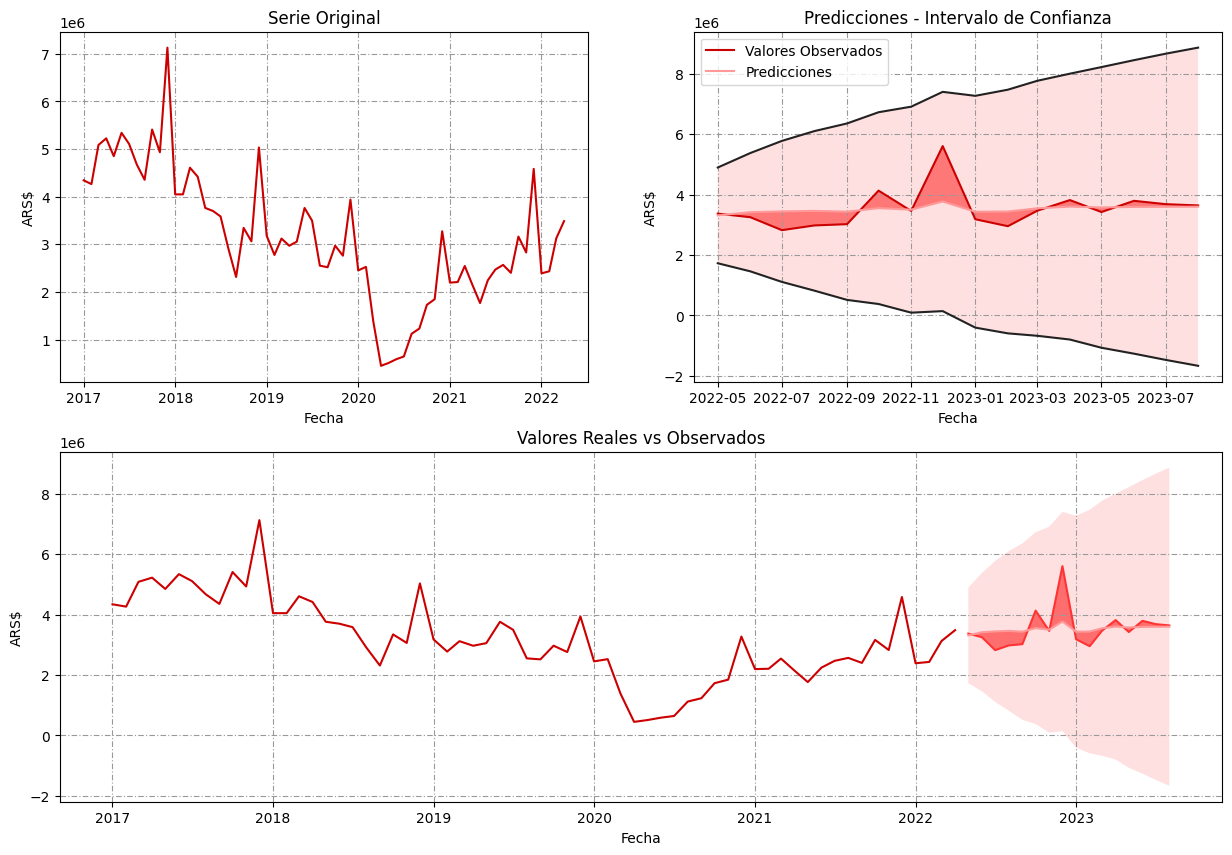

In [38]:
graficar_pred(train, test[:16], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int(), color = tema)

In [39]:
evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

MSE:	309256970025
MAE:	357021
RMSE:	556109
MAPE:	0.095


In [40]:
df_err = calcular_errores(test, modelos_alt_nombres, modelos_alt, 16)
df_err.style.apply(highlight_min, subset=['Akaike', 'MSE', 'MAE','RMSE','MAPE'])\
    .format({'Akaike': "{:.0f}",'MSE': "{:.2E}",'MAE': "{:.2E}",'RMSE': "{:.2E}",'MAPE': "{:.0%}"})

,Modelo,Akaike,MSE,MAE,RMSE,MAPE
0,AR 1,1939,1.32E+12,8.73E+05,1.15E+06,23%
1,MA 1,2072,1.23E+13,3.42E+06,3.51E+06,96%
2,ARMA 1-1,1929,6.91E+11,5.75E+05,8.31E+05,14%
3,"AR 1,2",1931,7.37E+11,6.09E+05,8.58E+05,15%
4,"MA 1,2",2057,1.24E+13,3.44E+06,3.52E+06,97%
5,"AR 1,2,12",8,1.29E+13,3.54E+06,3.60E+06,100%
6,"MA 1,2,12",2028,1.12E+13,3.24E+06,3.34E+06,91%
7,ARIMA 1-1-0,1899,4.25E+11,4.14E+05,6.52E+05,11%
8,ARIMA 0-1-1,1899,4.52E+11,4.31E+05,6.72E+05,11%
9,ARIMA 1-1-1,1901,4.24E+11,4.14E+05,6.51E+05,11%


## Serie Super

### Inciso 2 -  Grafico de la serie original

In [41]:
df = df_super
#df['diff1'] = df.ventas_ajustado.diff(periods = 1)
#df.diff1[0] = 0
tema = tema_verde
nombre_serie = 'Ventas Super'

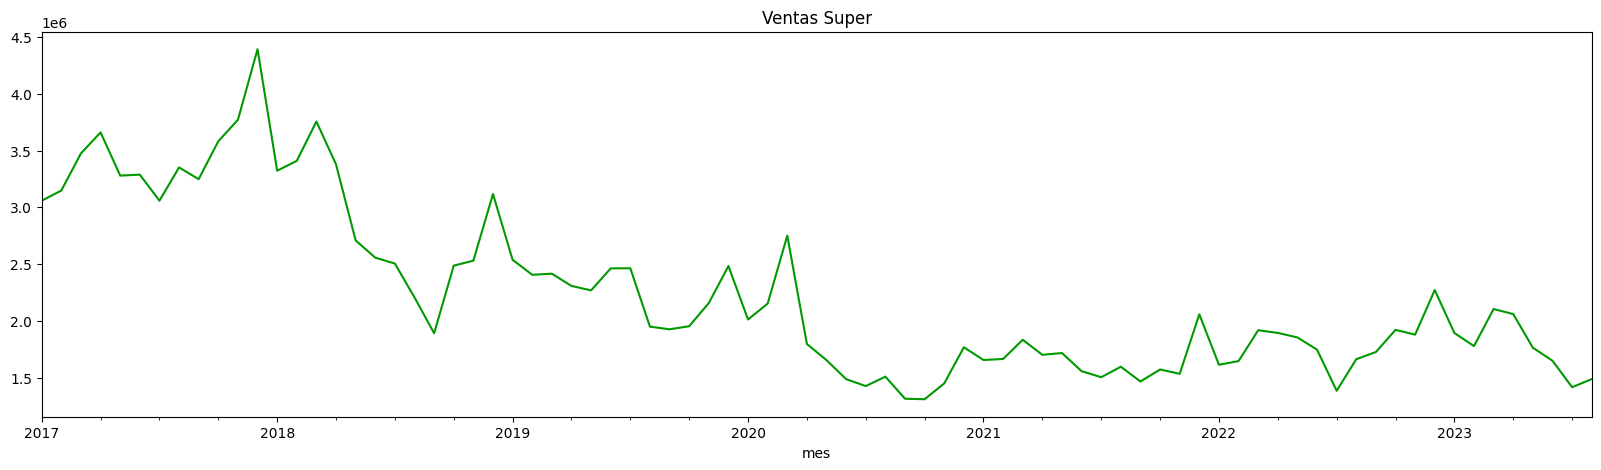

In [42]:
df.ventas_ajustado.plot(figsize=(20,5), title = nombre_serie, color = tema[0])
plt.show()

a simple vista no es estacionaria

### Inciso 3 - Funciones de ACF y PACF

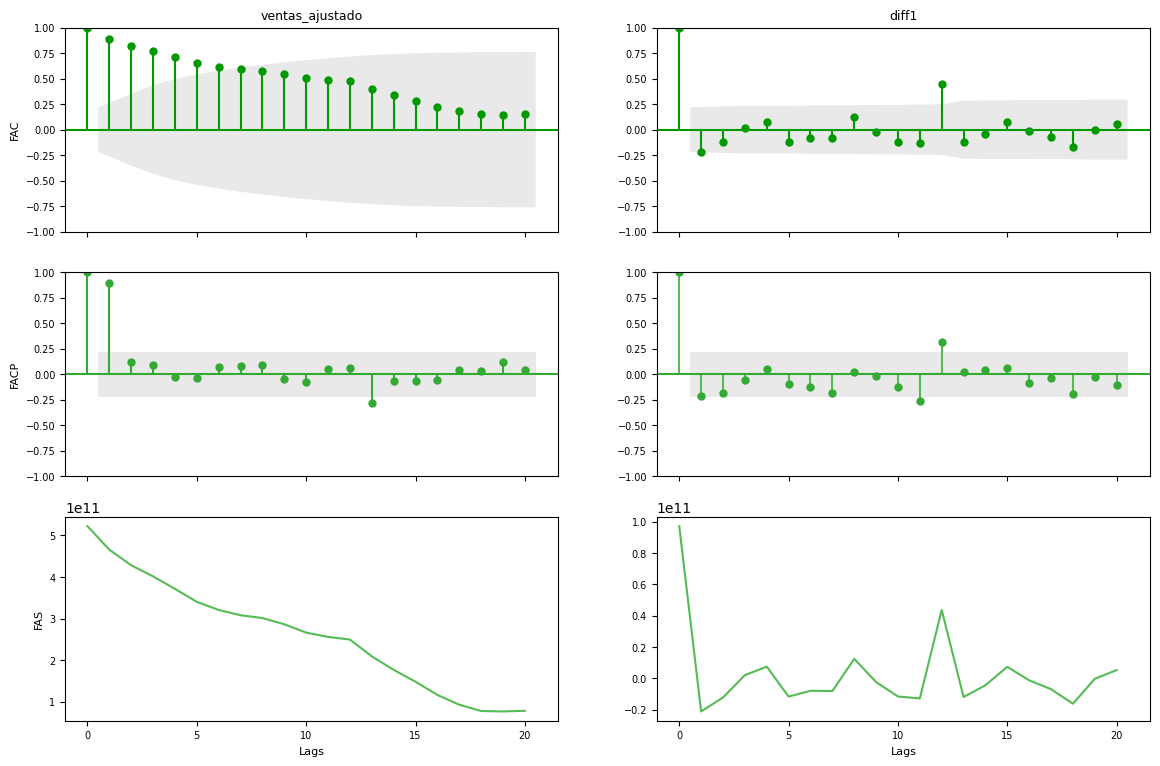

In [43]:
autocov_autocorr(df.ventas_ajustado, df.diff1, 20, tema)

### Inciso 4 - Pruebas de raices unitarias

In [44]:
print_test_adf(df.ventas_ajustado)
Phillips_Perron(df.ventas_ajustado)
kpss_test(df.ventas_ajustado)

________________________________________________________________________________________________________________________
Augmented Dickey-Fuller
Estadistico ADF		p-Valor	Estacionaridad	Modo
-2.7403 		0.0673 	No 		Constante sola
-1.4806 		0.8357 	No 		Constante y Tendencia Lineal
-2.9235 		0.3329 	No 		Constante y Tendencia Lineal y Cuadratica
-2.2243 		0.0251 	Si		Sin Contante ni Tendencia
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
Phillips-Perron
Estadistico PP	p-Valor		NumLags		Estacionaridad	nDiffs	Tipo_Regresion
-1.33		0.1699		12		No		1	n-No incluye término independiente ni lineal
-1.62		0.4717		12		No		1	c-Con término independiente, Sin término lineal
-3.46		0.0439		12		Si		1	ct-Incluye ambos términos
_____________________________________________________________________________________

Hasta ahora comprobamos que la serie original no es estacionaria

Pero los tests nos dan indicios de que la primer diferencia podria funcionar

arIma para todos

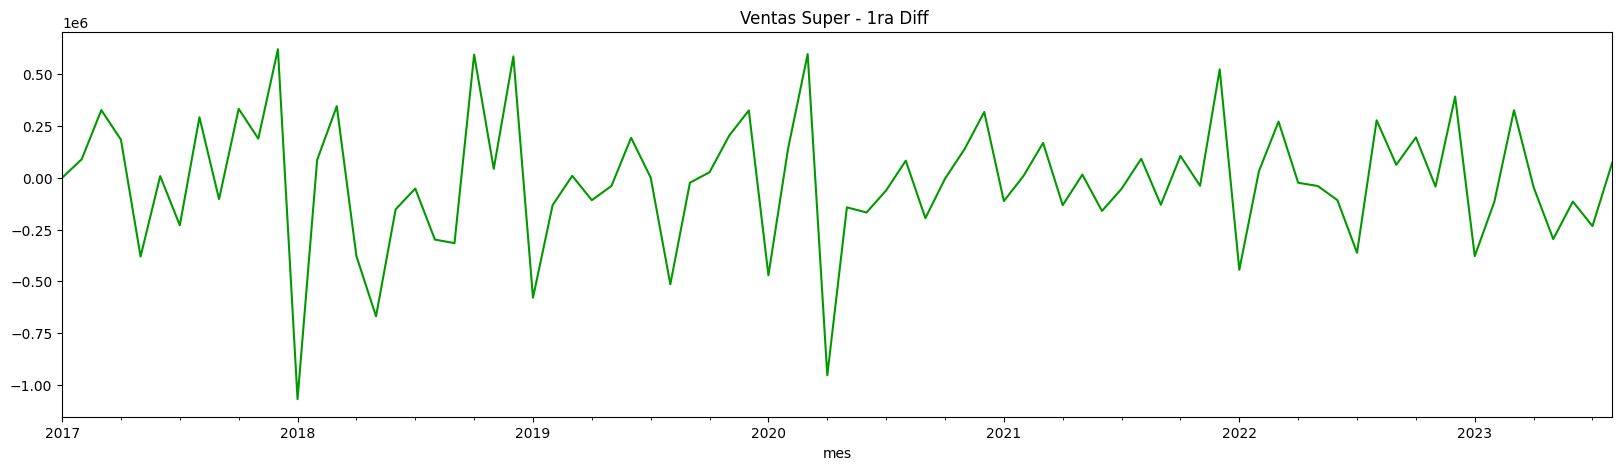

________________________________________________________________________________________________________________________
Augmented Dickey-Fuller
Estadistico ADF		p-Valor	Estacionaridad	Modo
-3.7467 		0.0035 	Si		Constante sola
-5.1607 		0.0001 	Si		Constante y Tendencia Lineal
-4.5201 		0.0061 	Si		Constante y Tendencia Lineal y Cuadratica
-2.9103 		0.0035 	Si		Sin Contante ni Tendencia
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
Phillips-Perron
Estadistico PP	p-Valor		NumLags		Estacionaridad	nDiffs	Tipo_Regresion
-12.75		0.0000		12		Si		0	n-No incluye término independiente ni lineal
-13.45		0.0000		12		Si		0	c-Con término independiente, Sin término lineal
-13.38		0.0000		12		Si		0	ct-Incluye ambos términos
_____________________________________________________________________________________

In [45]:
df.diff1.plot(figsize=(20,5), title = f"{nombre_serie} - 1ra Diff ", color = tema[0])
plt.show()
print_test_adf(df.diff1)
Phillips_Perron(df.diff1)
kpss_test(df.diff1)


### Inciso 5 - SARIMAX

In [46]:
sarimax = auto_arima(df.ventas_ajustado,
                     start_p=1, max_p=12,
                     start_d=1, max_d=3,
                     start_q=1, max_q=12,
                     start_P=0, max_P=12,
                     start_D=0, max_D=12,
                     start_Q=0, max_Q=12,
           seasonal=True, m=12, trace=True, stepwise=True, information_criterion='aic')
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2231.296, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2227.901, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2230.850, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2231.331, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2226.223, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2229.851, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2229.855, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2231.811, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2228.867, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2229.365, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.495 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1112.112
Date:                Wed, 15 Nov 2023   AIC                           2226.223
Time:                        03:33:45   BIC                           2228.593
Sample:                    01-01-2017   HQIC                          2227.173
                         - 08-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       9.76e+10   1.17e+10      8.366      0.000    7.47e+10     1.2e+11
===================================================================================
Ljung-Box (L1) (Q):                   3.90   Jarque-Bera (JB):                10.08
Prob(Q):                              0.05   Prob(JB):                         0.01
Heteroskedasticity (H):               0.35   Skew:                            -0.57
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Inciso 6 - Predecir

In [47]:
# Separacion Train/Test
train = df.iloc[:round(len(df)*.80)].ventas_ajustado
test = df.iloc[round(len(df)*.80):].ventas_ajustado

In [48]:
modelo_sarima = SARIMAX(train, order=(0,1,0), seasonal_order=(0,0,0,12))
modelo_sarima = modelo_sarima.fit()
print(modelo_sarima.summary())

                               SARIMAX Results                                
Dep. Variable:        ventas_ajustado   No. Observations:                   64
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -890.400
Date:                Wed, 15 Nov 2023   AIC                           1782.800
Time:                        03:33:45   BIC                           1784.943
Sample:                    01-01-2017   HQIC                          1783.643
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.088e+11   1.48e+10      7.377      0.000    7.99e+10    1.38e+11
Ljung-Box (L1) (Q):                   3.22   Jarque-Bera (JB):                 8.09
Prob(Q):                              0.07   Pr

### Inciso 7 - Probar otros modelos

In [49]:
modelos_alt = []
modelos_alt.append(SARIMAX(train, order=(1,0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,0,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,1,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,1,12)).fit())

modelos_alt.append(SARIMAX(train, order=((1,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,0), seasonal_order=(1,0,0,12)).fit())

modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())

modelos_alt_nombres = ['AR 1','MA 1','ARMA 1-1','AR 1,2','MA 1,2','AR 1,2,12','MA 1,2,12',
                       'ARIMA 1-1-0','ARIMA 0-1-1','ARIMA 1-1-1','ARIMA 1,2-1-0','ARIMA 0-1-1,2','ARIMA 1,2,12-1-0','ARIMA 0-1-1,2,12',
                       'SARIMA 1-1-0 Season AR 1','SARIMA 1-1-0 Season MA 1','SARIMA 1-1-0 Season ARMA 1-1',
                       'AR 1,12','ARIMA 1,12-1-0',
                       'MA 1,12','ARIMA 0-1-1,12',
                       'ARIMA 0-0-0 Season AR 1',
                       'AR 12','MA 12','ARIMA 12-1-0','ARIMA 0-1-12']

i = 0
for mod in modelos_alt:
    print(f'Modelo {i}-Akaike: {round(mod.aic,4)}-\t{modelos_alt_nombres[i]}')
    i += 1

Modelo 0-Akaike: 1816.8454-	AR 1
Modelo 1-Akaike: 2024.3879-	MA 1
Modelo 2-Akaike: 1814.813-	ARMA 1-1
Modelo 3-Akaike: 1815.9623-	AR 1,2
Modelo 4-Akaike: 2011.0293-	MA 1,2
Modelo 5-Akaike: 1817.2586-	AR 1,2,12
Modelo 6-Akaike: 1978.0866-	MA 1,2,12
Modelo 7-Akaike: 1783.9531-	ARIMA 1-1-0
Modelo 8-Akaike: 1783.9858-	ARIMA 0-1-1
Modelo 9-Akaike: 1785.9939-	ARIMA 1-1-1
Modelo 10-Akaike: 1786.0385-	ARIMA 1,2-1-0
Modelo 11-Akaike: 1785.9368-	ARIMA 0-1-1,2
Modelo 12-Akaike: 1796.7789-	ARIMA 1,2,12-1-0
Modelo 13-Akaike: 1833.9891-	ARIMA 0-1-1,2,12
Modelo 14-Akaike: 1785.8297-	SARIMA 1-1-0 Season AR 1
Modelo 15-Akaike: 1785.8338-	SARIMA 1-1-0 Season MA 1
Modelo 16-Akaike: 1787.7616-	SARIMA 1-1-0 Season ARMA 1-1
Modelo 17-Akaike: 6.0-	AR 1,12
Modelo 18-Akaike: 1794.0012-	ARIMA 1,12-1-0
Modelo 19-Akaike: 1998.9021-	MA 1,12
Modelo 20-Akaike: 1796.9266-	ARIMA 0-1-1,12
Modelo 21-Akaike: 1955.1976-	ARIMA 0-0-0 Season AR 1
Modelo 22-Akaike: 1955.1976-	AR 12
Modelo 23-Akaike: 2024.6908-	MA 12
Modelo 24

In [50]:
modelo_pick = modelos_alt[7]
print(modelo_pick.summary())


                               SARIMAX Results                                
Dep. Variable:        ventas_ajustado   No. Observations:                   64
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -889.977
Date:                Wed, 15 Nov 2023   AIC                           1783.953
Time:                        03:33:47   BIC                           1788.239
Sample:                    01-01-2017   HQIC                          1785.639
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0757      0.074     -1.023      0.306      -0.221       0.069
sigma2      1.069e+11   1.63e-13   6.54e+23      0.000    1.07e+11    1.07e+11
Ljung-Box (L1) (Q):                   1.41   Jarque-

Dados los resultados finales de los tests, principalmente el AIC porque es facil de evaluar a simple vista

Concluimos que el mejor modelo es el que propuso AutoARIMA (Un ARIMA 1-1-0 con Season AR 1 (12))

### Inciso 8 - Analisis de Diagnostico

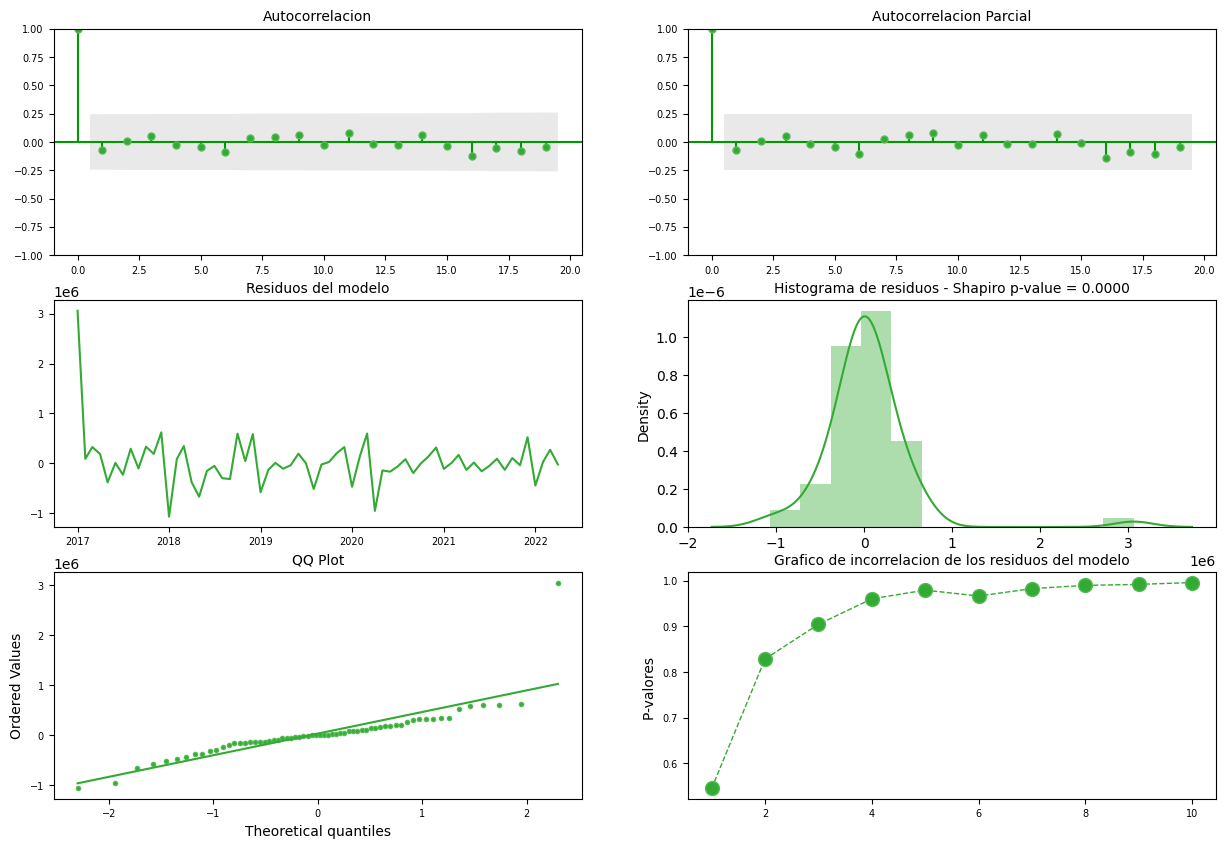

In [51]:
prueba_residuos(modelo_sarima.resid, color = tema)

La hipotesis nula es que los datos son independientes
vemos que generalmente no rechazan

aprueba el test

notamos que los residuos son ruido blanco, lo cual es favorable

pero que su distribucion no es normal, lo que reduce la validez del modelo para efectuar predicciones

### Inciso 9 - Pronosticar

In [52]:
predicciones_sarima = modelo_sarima.get_forecast(16)

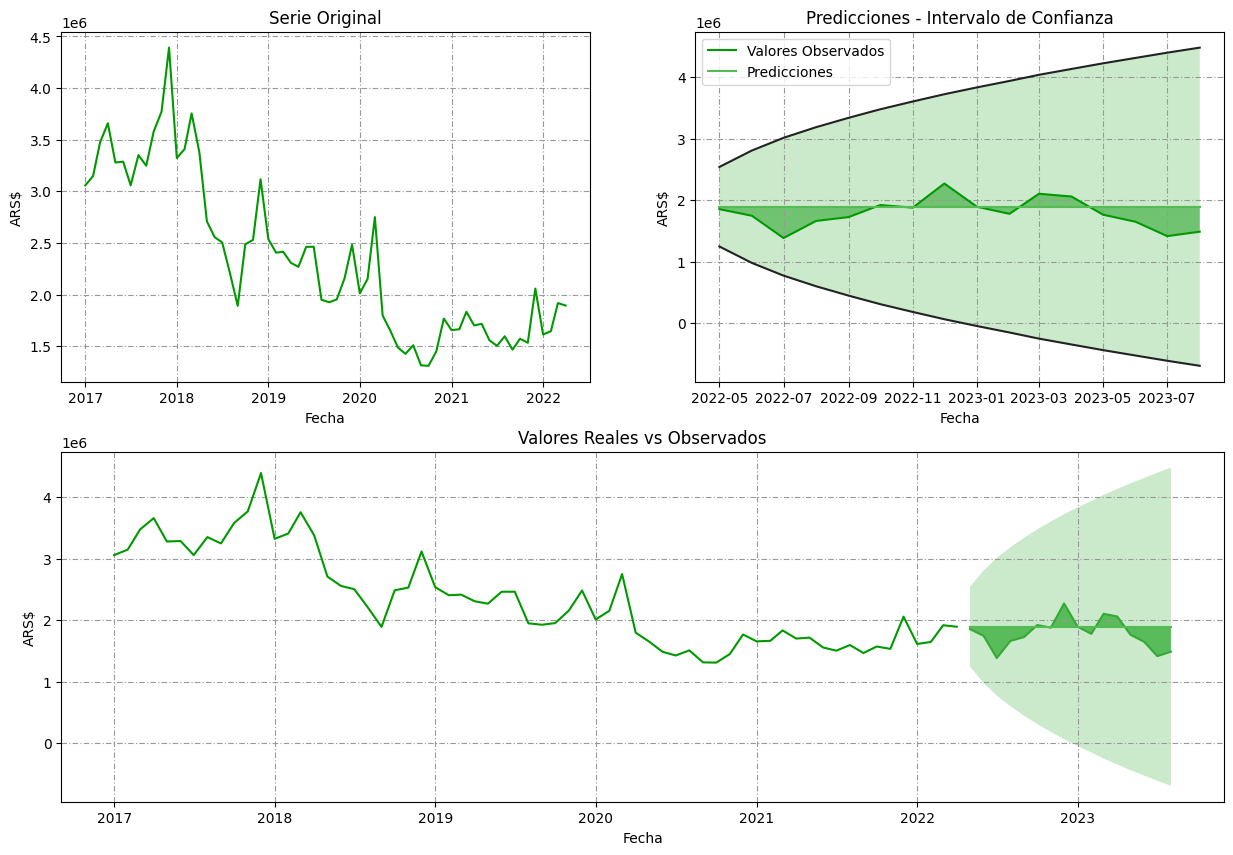

In [53]:
graficar_pred(train, test[:16], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int(), color = tema)

In [54]:
evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

MSE:	66443660197
MAE:	204158
RMSE:	257767
MAPE:	0.123


In [55]:
df_err = calcular_errores(test, modelos_alt_nombres, modelos_alt, 16)
df_err.style.apply(highlight_min, subset=['Akaike', 'MSE', 'MAE','RMSE','MAPE'])\
    .format({'Akaike': "{:.0f}",'MSE': "{:.2E}",'MAE': "{:.2E}",'RMSE': "{:.2E}",'MAPE': "{:.0%}"})

,Modelo,Akaike,MSE,MAE,RMSE,MAPE
0,AR 1,1817,5.80E+10,1.88E+05,2.41E+05,11%
1,MA 1,2024,3.07E+12,1.72E+06,1.75E+06,96%
2,ARMA 1-1,1815,5.54E+10,1.84E+05,2.35E+05,11%
3,"AR 1,2",1816,5.57E+10,1.84E+05,2.36E+05,11%
4,"MA 1,2",2011,3.05E+12,1.72E+06,1.75E+06,96%
5,"AR 1,2,12",1817,6.59E+10,2.05E+05,2.57E+05,12%
6,"MA 1,2,12",1978,2.92E+12,1.68E+06,1.71E+06,94%
7,ARIMA 1-1-0,1784,6.68E+10,2.05E+05,2.58E+05,12%
8,ARIMA 0-1-1,1784,6.65E+10,2.04E+05,2.58E+05,12%
9,ARIMA 1-1-1,1786,6.68E+10,2.05E+05,2.58E+05,12%


## Serie Cowork

### Inciso 2 -  Grafico de la serie original

In [56]:
df = df_cowork
#df['diff1'] = df.ventas_ajustado.diff(periods = 1)
#df.diff1[0] = 0
tema = tema_azul
nombre_serie = 'Ventas Cowork'

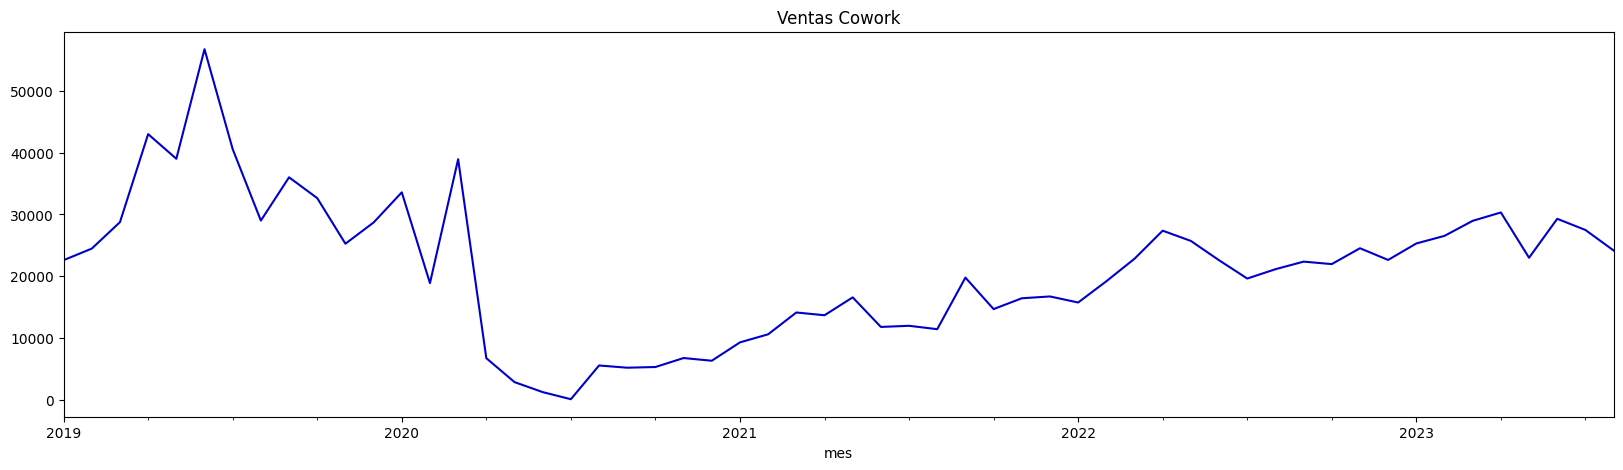

In [57]:
df.ventas_ajustado.plot(figsize=(20,5), title = nombre_serie, color = tema[0])
plt.show()

a simple vista no es estacionaria

### Inciso 3 - Funciones de ACF y PACF

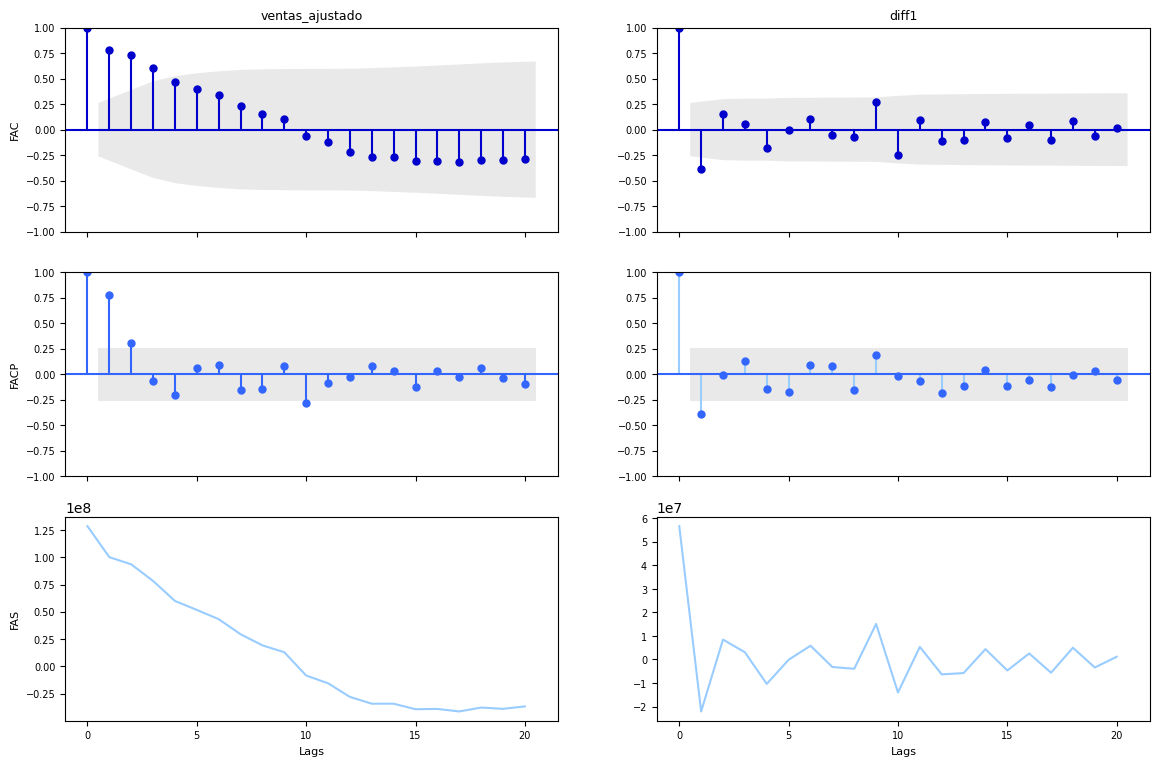

In [58]:
autocov_autocorr(df.ventas_ajustado, df.diff1, 20, tema)

### Inciso 4 - Pruebas de raices unitarias

In [59]:
print_test_adf(df.ventas_ajustado)
Phillips_Perron(df.ventas_ajustado)
kpss_test(df.ventas_ajustado)

________________________________________________________________________________________________________________________
Augmented Dickey-Fuller
Estadistico ADF		p-Valor	Estacionaridad	Modo
-1.7020 		0.4301 	No 		Constante sola
-1.6563 		0.7696 	No 		Constante y Tendencia Lineal
-2.9501 		0.3195 	No 		Constante y Tendencia Lineal y Cuadratica
-0.7441 		0.3940 	No 		Sin Contante ni Tendencia
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
Phillips-Perron
Estadistico PP	p-Valor		NumLags		Estacionaridad	nDiffs	Tipo_Regresion
-0.91		0.3234		11		No		1	n-No incluye término independiente ni lineal
-2.72		0.0707		11		No		1	c-Con término independiente, Sin término lineal
-2.74		0.2196		11		No		1	ct-Incluye ambos términos
____________________________________________________________________________________

Hasta ahora comprobamos que la serie original no es estacionaria

Pero los tests nos dan indicios de que la primer diferencia podria funcionar

arIma para todos

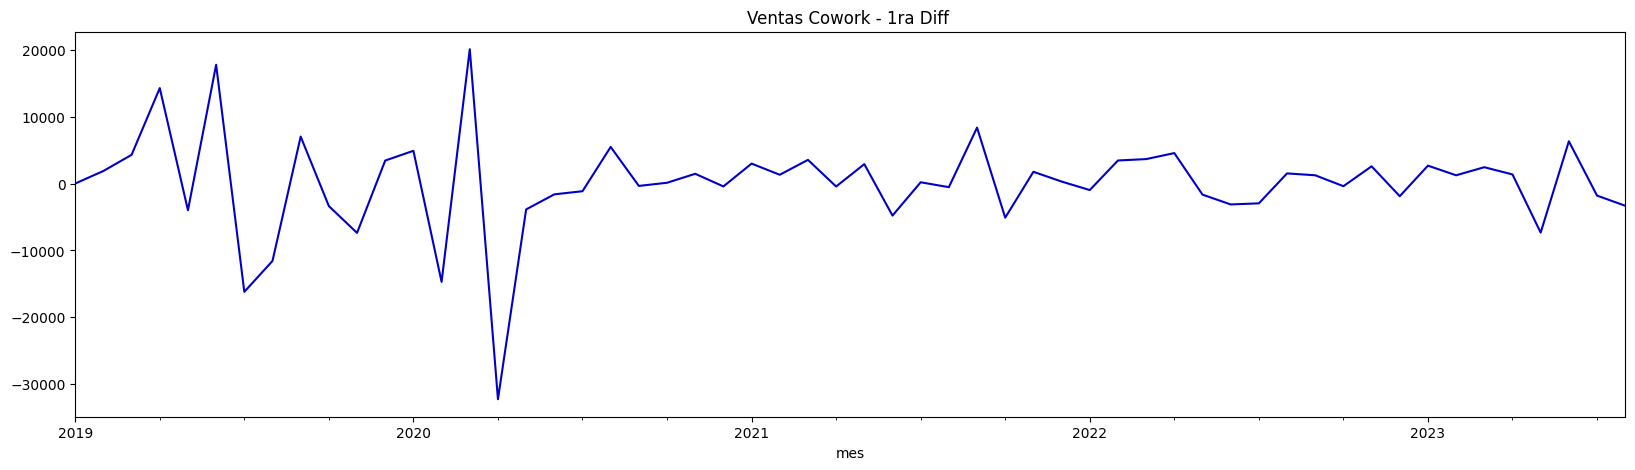

________________________________________________________________________________________________________________________
Augmented Dickey-Fuller
Estadistico ADF		p-Valor	Estacionaridad	Modo
-10.9820 		0.0000 	Si		Constante sola
-10.8865 		0.0000 	Si		Constante y Tendencia Lineal
-10.8108 		0.0000 	Si		Constante y Tendencia Lineal y Cuadratica
-11.0846 		0.0000 	Si		Sin Contante ni Tendencia
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
Phillips-Perron
Estadistico PP	p-Valor		NumLags		Estacionaridad	nDiffs	Tipo_Regresion
-11.25		0.0000		11		Si		0	n-No incluye término independiente ni lineal
-11.14		0.0000		11		Si		0	c-Con término independiente, Sin término lineal
-11.17		0.0000		11		Si		0	ct-Incluye ambos términos
_________________________________________________________________________________

In [60]:
df.diff1.plot(figsize=(20,5), title = f"{nombre_serie} - 1ra Diff ", color = tema[0])
plt.show()
print_test_adf(df.diff1)
Phillips_Perron(df.diff1)
kpss_test(df.diff1)


### Inciso 5 - SARIMAX

In [61]:
sarimax = auto_arima(df.ventas_ajustado,
                     start_p=1, max_p=12,
                     start_d=1, max_d=3,
                     start_q=1, max_q=12,
                     start_P=0, max_P=12,
                     start_D=0, max_D=12,
                     start_Q=0, max_Q=12,
           seasonal=True, m=12, trace=True, stepwise=True, information_criterion='aic')
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1157.112, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1208.573, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1160.276, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1189.069, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1290.621, Time=0.02 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1157.054, Time=0.08 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=1158.530, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=1158.943, Time=0.11 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1156.972, Time=0.07 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=1158.861, Time=0.13 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=1160.665, Time=0.22 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1159.857, Time=0.05 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1157.452, Time=0.09 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=1156.897, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   56
Model:             SARIMAX(1, 0, 2)x(0, 0, [1], 12)   Log Likelihood                -572.449
Date:                              Wed, 15 Nov 2023   AIC                           1156.897
Time:                                      03:33:54   BIC                           1169.049
Sample:                                  01-01-2019   HQIC                          1161.608
                                       - 08-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4584.2328   2527.447      1.814      0.070    -369.472    9537.938
ar.L1          0.7788      0.100      7.759      0.000       0.582       0.976
ma.L1         -0.2806      0.135     -2.074      0.038      -0.546      -0.015
ma.L2          0.3507      0.113      3.095      0.002       0.129       0.573
ma.S.L12      -0.2261      0.121     -1.864      0.062      -0.464       0.012
sigma2      3.353e+07      0.298   1.12e+08      0.000    3.35e+07    3.35e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.11
Prob(Q):                              0.96   Prob(JB):                         0.08
Heteroskedasticity (H):               0.12   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.68e+23. Standard errors may be unstable.
"""

### Inciso 6 - Predecir

In [62]:
# Separacion Train/Test
train = df.iloc[:round(len(df)*.80)].ventas_ajustado
test = df.iloc[round(len(df)*.80):].ventas_ajustado

In [63]:
modelo_sarima = SARIMAX(train, order=(1,0,2), seasonal_order=(0,0,1,12))
modelo_sarima = modelo_sarima.fit()
print(modelo_sarima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                      ventas_ajustado   No. Observations:                   45
Model:             SARIMAX(1, 0, 2)x(0, 0, [1], 12)   Log Likelihood                -466.924
Date:                              Wed, 15 Nov 2023   AIC                            943.849
Time:                                      03:33:54   BIC                            952.882
Sample:                                  01-01-2019   HQIC                           947.216
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9737      0.043     22.532      0.000       0.889       1.058
ma.L1         -0.36

### Inciso 7 - Probar otros modelos

In [64]:
modelos_alt = []
modelos_alt.append(SARIMAX(train, order=(1,0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,0,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,1,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,1,12)).fit())

modelos_alt.append(SARIMAX(train, order=((1,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,0), seasonal_order=(1,0,0,12)).fit())

modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())

modelos_alt_nombres = ['AR 1','MA 1','ARMA 1-1','AR 1,2','MA 1,2','AR 1,2,12','MA 1,2,12',
                       'ARIMA 1-1-0','ARIMA 0-1-1','ARIMA 1-1-1','ARIMA 1,2-1-0','ARIMA 0-1-1,2','ARIMA 1,2,12-1-0','ARIMA 0-1-1,2,12',
                       'SARIMA 1-1-0 Season AR 1','SARIMA 1-1-0 Season MA 1','SARIMA 1-1-0 Season ARMA 1-1',
                       'AR 1,12','ARIMA 1,12-1-0',
                       'MA 1,12','ARIMA 0-1-1,12',
                       'ARIMA 0-0-0 Season AR 1',
                       'AR 12','MA 12','ARIMA 12-1-0','ARIMA 0-1-12']

i = 0
for mod in modelos_alt:
    print(f'Modelo {i}-Akaike: {round(mod.aic,4)}-\t{modelos_alt_nombres[i]}')
    i += 1

Modelo 0-Akaike: 944.573-	AR 1
Modelo 1-Akaike: 1010.5959-	MA 1
Modelo 2-Akaike: 941.6765-	ARMA 1-1
Modelo 3-Akaike: 940.3918-	AR 1,2
Modelo 4-Akaike: 997.8068-	MA 1,2
Modelo 5-Akaike: 8.0-	AR 1,2,12
Modelo 6-Akaike: 1010.3023-	MA 1,2,12
Modelo 7-Akaike: 917.4981-	ARIMA 1-1-0
Modelo 8-Akaike: 918.7738-	ARIMA 0-1-1
Modelo 9-Akaike: 919.5203-	ARIMA 1-1-1
Modelo 10-Akaike: 919.3858-	ARIMA 1,2-1-0
Modelo 11-Akaike: 919.5265-	ARIMA 0-1-1,2
Modelo 12-Akaike: 923.0307-	ARIMA 1,2,12-1-0
Modelo 13-Akaike: 923.8917-	ARIMA 0-1-1,2,12
Modelo 14-Akaike: 918.3739-	SARIMA 1-1-0 Season AR 1
Modelo 15-Akaike: 918.3923-	SARIMA 1-1-0 Season MA 1
Modelo 16-Akaike: 920.3715-	SARIMA 1-1-0 Season ARMA 1-1
Modelo 17-Akaike: 6.0-	AR 1,12
Modelo 18-Akaike: 921.098-	ARIMA 1,12-1-0
Modelo 19-Akaike: 1005.6936-	MA 1,12
Modelo 20-Akaike: 919.7596-	ARIMA 0-1-1,12
Modelo 21-Akaike: 1033.9313-	ARIMA 0-0-0 Season AR 1
Modelo 22-Akaike: 1033.9313-	AR 12
Modelo 23-Akaike: 1032.9516-	MA 12
Modelo 24-Akaike: 923.2701-	ARIM

In [65]:
modelo_pick = modelos_alt[15]
print(modelo_pick.summary())


                                      SARIMAX Results                                       
Dep. Variable:                      ventas_ajustado   No. Observations:                   45
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -456.196
Date:                              Wed, 15 Nov 2023   AIC                            918.392
Time:                                      03:33:56   BIC                            923.745
Sample:                                  01-01-2019   HQIC                           920.377
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3501      0.081     -4.315      0.000      -0.509      -0.191
ma.S.L12      -0.16

Dados los resultados finales de los tests, principalmente el AIC porque es facil de evaluar a simple vista

Concluimos que el mejor modelo es el que propuso AutoARIMA (Un ARIMA 1-1-0 con Season AR 1 (12))

### Inciso 8 - Analisis de Diagnostico

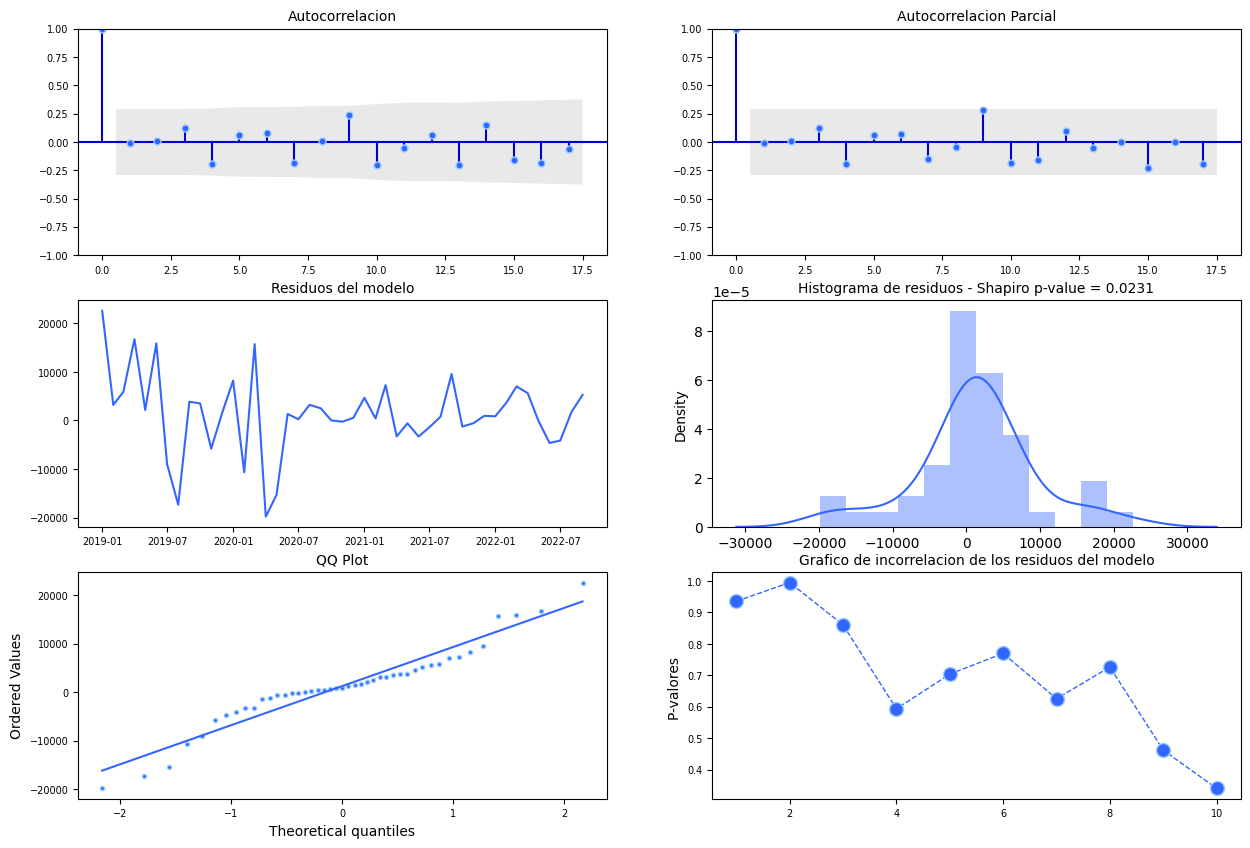

In [66]:
prueba_residuos(modelo_sarima.resid, color = tema)

La hipotesis nula es que los datos son independientes
vemos que generalmente no rechazan

aprueba el test

notamos que los residuos son ruido blanco, lo cual es favorable

pero que su distribucion no es normal, lo que reduce la validez del modelo para efectuar predicciones

### Inciso 9 - Pronosticar

In [67]:
#predicciones_sarima = modelo_sarima.get_forecast(10)
predicciones_sarima = modelo_pick.get_forecast(10)

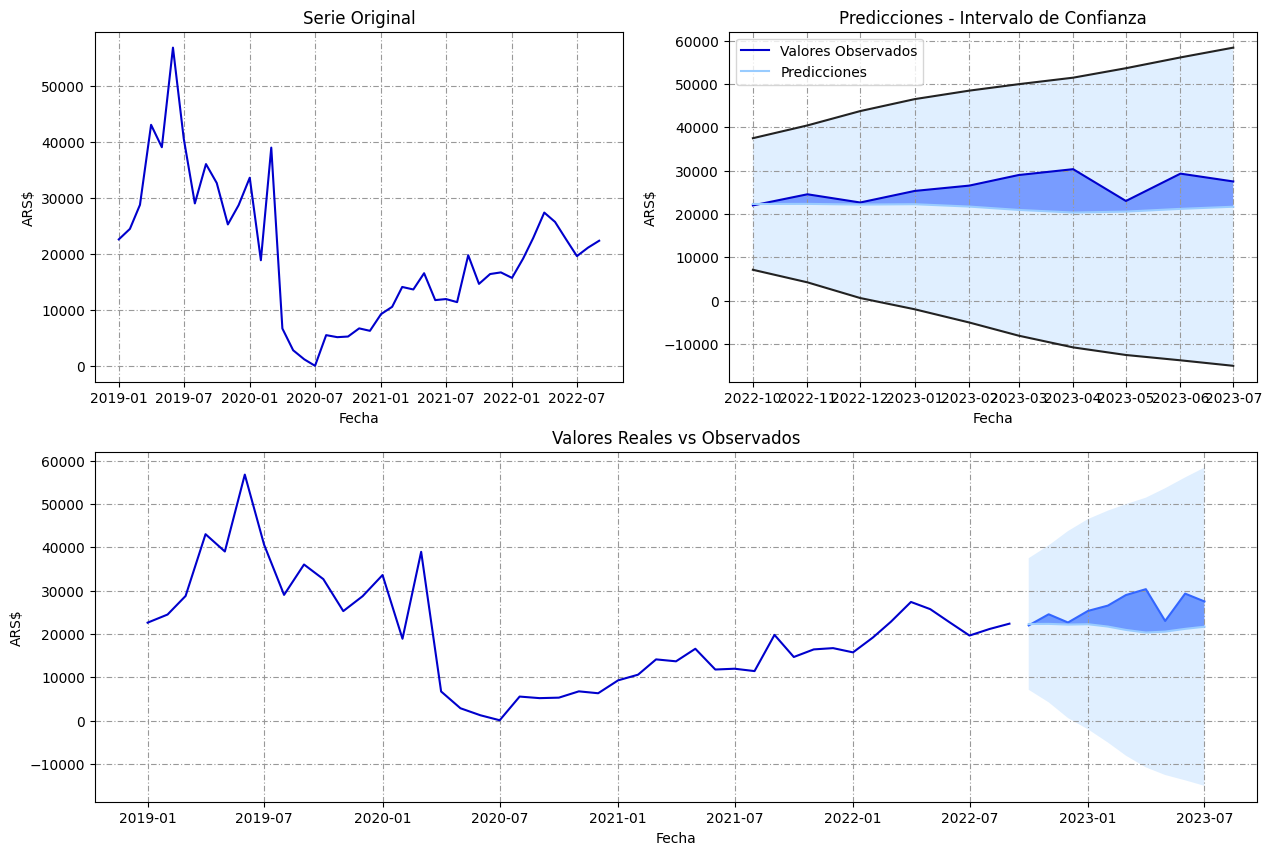

In [68]:
graficar_pred(train, test[:10], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int(), color = tema)

In [69]:
evaluar_metricas(test[:10], predicciones_sarima.predicted_mean )

MSE:	30923348
MAE:	4540
RMSE:	5561
MAPE:	0.163


In [70]:
df_err = calcular_errores(test, modelos_alt_nombres, modelos_alt, 10)
df_err.style.apply(highlight_min, subset=['Akaike', 'MSE', 'MAE','RMSE','MAPE'])\
    .format({'Akaike': "{:.0f}",'MSE': "{:.2E}",'MAE': "{:.2E}",'RMSE': "{:.2E}",'MAPE': "{:.0%}"})

,Modelo,Akaike,MSE,MAE,RMSE,MAPE
0,AR 1,945,1.31E+08,1.02E+04,1.15E+04,37%
1,MA 1,1011,6.52E+08,2.51E+04,2.55E+04,96%
2,ARMA 1-1,942,6.64E+07,7.16E+03,8.15E+03,26%
3,"AR 1,2",940,7.21E+07,7.47E+03,8.49E+03,27%
4,"MA 1,2",998,6.14E+08,2.40E+04,2.48E+04,91%
5,"AR 1,2,12",8,6.84E+08,2.60E+04,2.62E+04,100%
6,"MA 1,2,12",1010,5.18E+08,2.18E+04,2.28E+04,83%
7,ARIMA 1-1-0,917,2.35E+07,3.95E+03,4.85E+03,14%
8,ARIMA 0-1-1,919,2.40E+07,4.00E+03,4.90E+03,14%
9,ARIMA 1-1-1,920,2.32E+07,3.92E+03,4.82E+03,14%


### Inciso 10 - VAR

In [71]:
serieVAR = pd.concat([df_retail.diff1, df_super.diff1, df_cowork.diff1], axis=1)
serieVAR.columns = ['retail','super','cowork']
serieVAR.dropna(inplace=True)
serieVAR.head()


,retail,super,cowork
mes,,,
2019-01-01,-1.854522e+06,-578948.691489,0.000000
2019-02-01,-4.023486e+05,-131898.015787,1873.841616
2019-03-01,3.441337e+05,9715.516069,4286.247280
2019-04-01,-1.508929e+05,-107802.953105,14258.914354
2019-05-01,8.644093e+04,-39165.552559,-3992.029044


In [72]:
split = .8
train2 = serieVAR.iloc[:round(len(serieVAR)*split)]
test2 = serieVAR.iloc[round(len(serieVAR)*split):]

In [74]:
grangers_causation_matrix(train2, variables = train2.columns, maxlag=2, verbose=True)

Y = retail, X = retail, P Values = [(0.9999999260293027, 1), (1.0, 2)]
Y = super, X = retail, P Values = [(0.33605958086470067, 1), (0.5191819678523424, 2)]
Y = cowork, X = retail, P Values = [(0.08309929391979647, 1), (0.10125786983761029, 2)]
Y = retail, X = super, P Values = [(0.2828901027638382, 1), (0.03748488512208546, 2)]
Y = super, X = super, P Values = [(0.9999999314517706, 1), (0.9999999999999919, 2)]
Y = cowork, X = super, P Values = [(0.4864238480309463, 1), (0.027204551138603646, 2)]
Y = retail, X = cowork, P Values = [(0.5936712865421045, 1), (0.7982835485573418, 2)]
Y = super, X = cowork, P Values = [(0.6218372583609308, 1), (0.2088987391366261, 2)]
Y = cowork, X = cowork, P Values = [(0.9999998983453864, 1), (0.999999999999992, 2)]


,retail_x,super_x,cowork_x
retail_y,1.000000,0.037485,0.593671
super_y,0.336060,1.000000,0.208899
cowork_y,0.083099,0.027205,1.000000


In [75]:
from statsmodels.tsa.api import VAR

In [77]:
model = VAR(train2)

In [79]:
x = model.select_order(maxlags=2)
x.summary()

,AIC,BIC,FPE,HQIC
0,69.28,69.40*,1.226e+30,69.33*
1,69.17*,69.66,1.097e+30*,69.35
2,69.34,70.20,1.314e+30,69.66


In [80]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Nov, 2023
Time:                     03:39:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    69.6858
Nobs:                     44.0000    HQIC:                   69.3796
Log likelihood:          -1697.68    FPE:                1.13103e+30
AIC:                      69.1992    Det(Omega_mle):     8.71183e+29
--------------------------------------------------------------------
Results for equation retail
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const        -36983.135129    103949.147194           -0.356           0.722
L1.retail        -0.054007         0.190048           -0.284           0.776
L1.super         -0.955710         0.589862           -1.620           0.10

In [81]:
results = model.fit(maxlags=2, ic='aic', verbose=1)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 0, FPE -> 1, HQIC ->  0>
Using 1 based on aic criterion


In [82]:
print(results.summary()._resid_info())

Correlation matrix of residuals
            retail     super    cowork
retail    1.000000  0.626884  0.212856
super     0.626884  1.000000  0.509223
cowork    0.212856  0.509223  1.000000




In [83]:
normality = results.test_normality()
print(normality.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         53.83          12.59   0.000  6
----------------------------------------


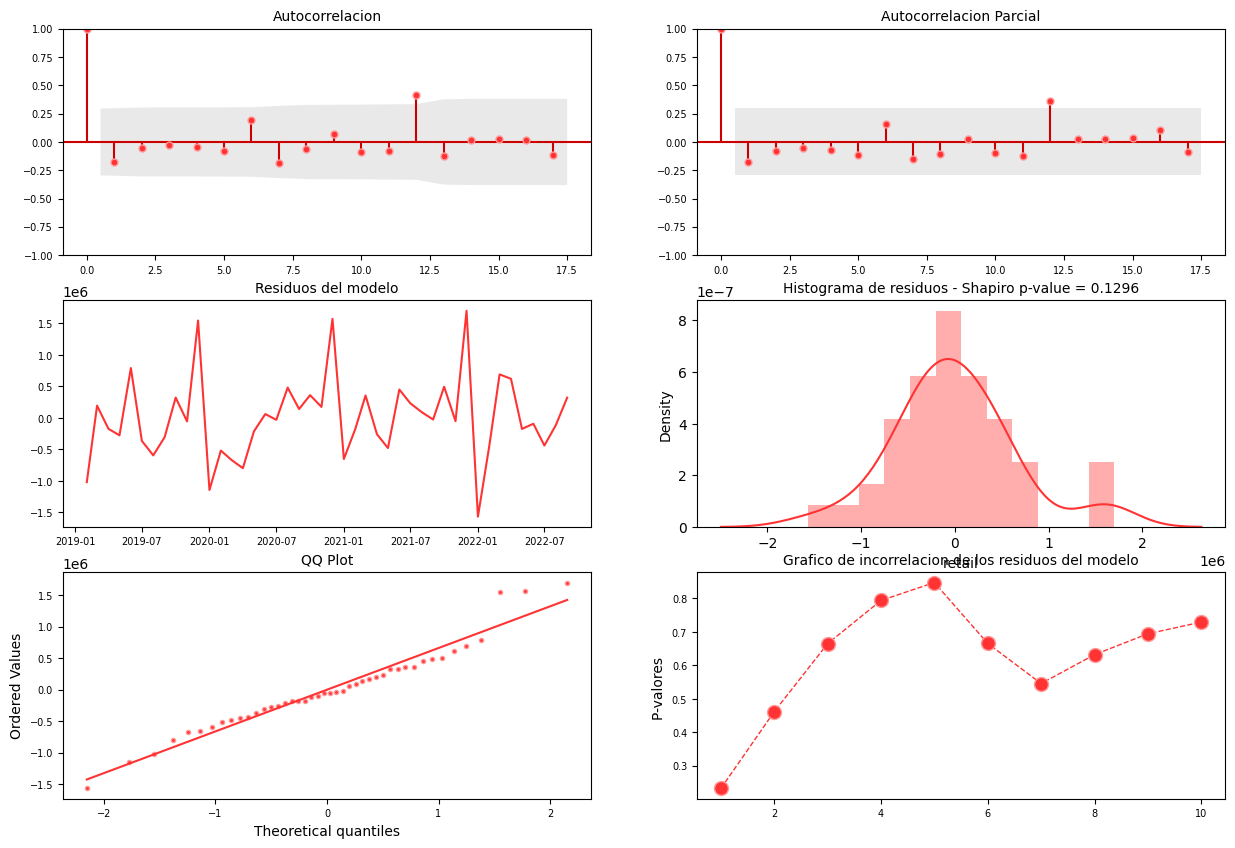

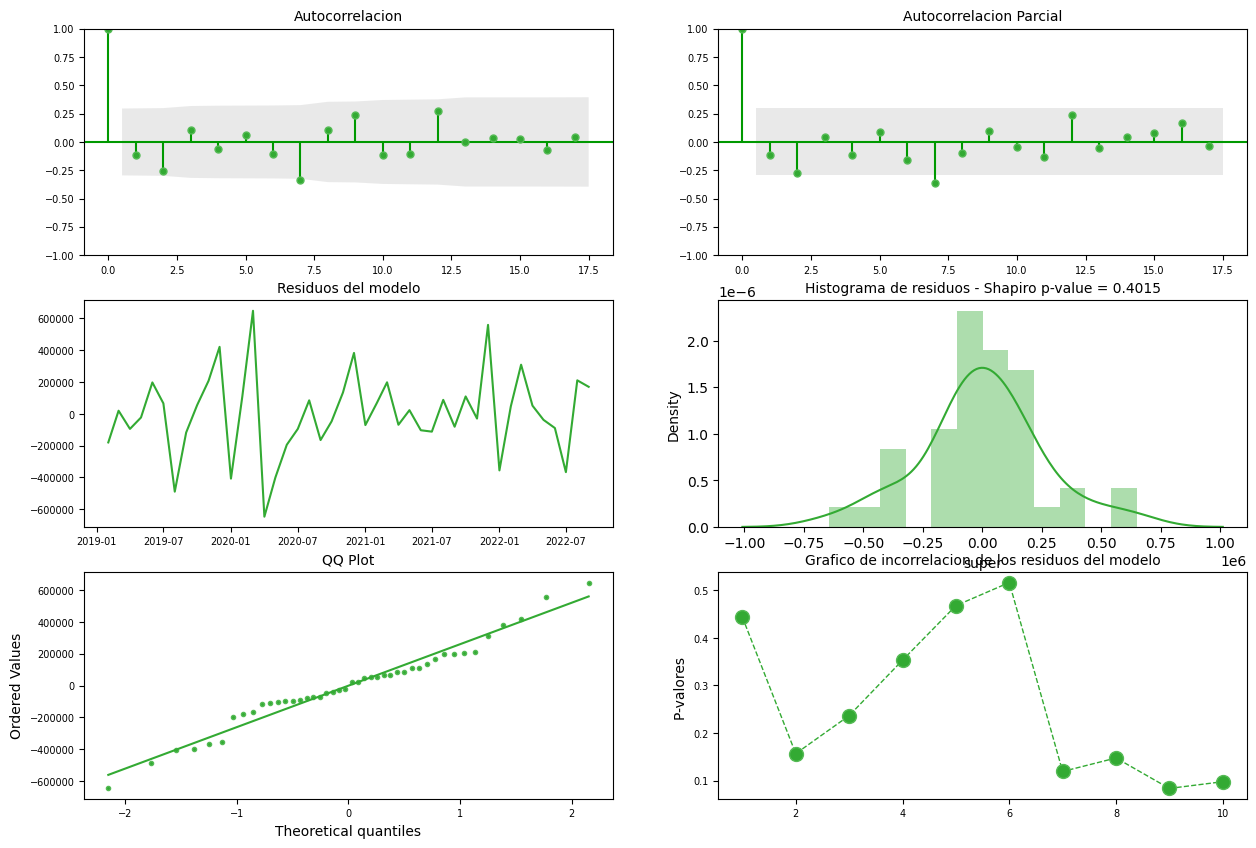

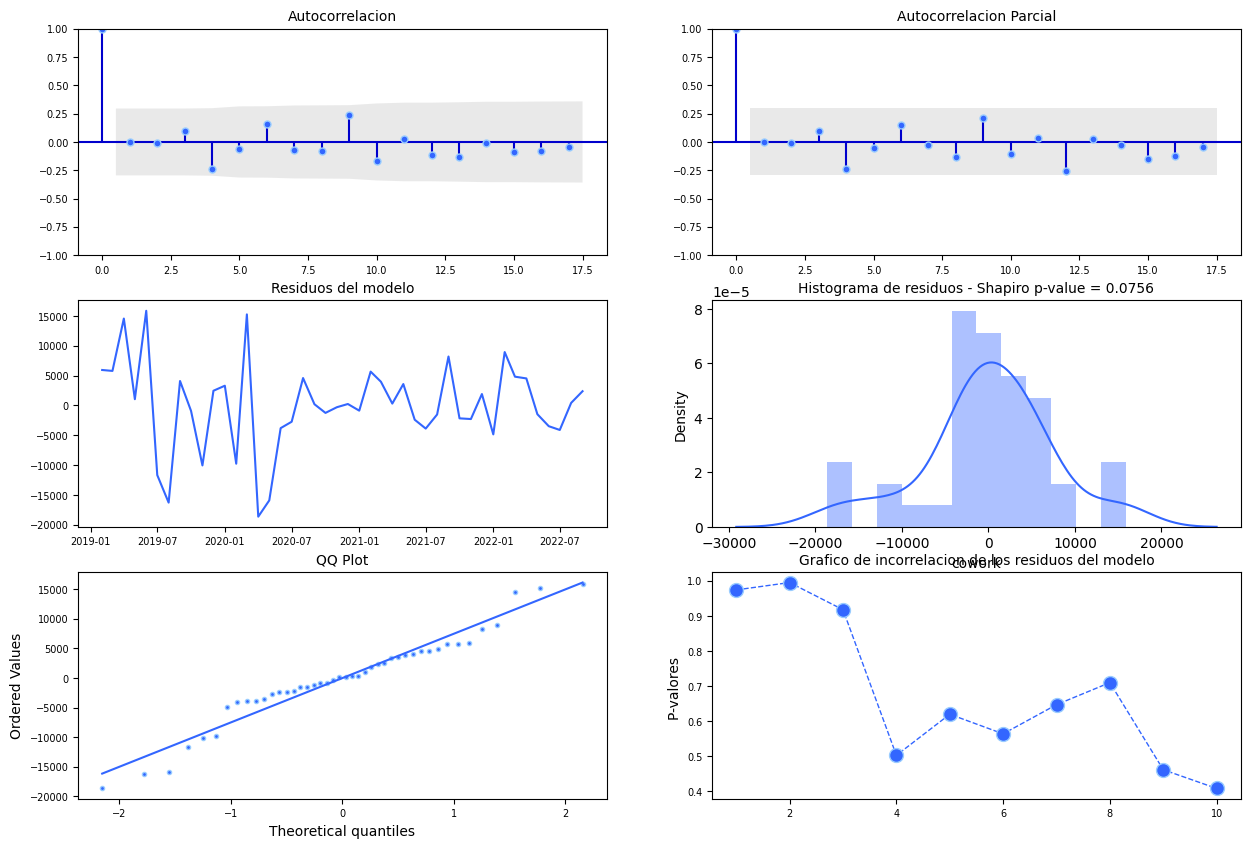

In [92]:
prueba_residuos(results.resid['retail'], tema_rojo)
prueba_residuos(results.resid['super'], tema_verde)
prueba_residuos(results.resid['cowork'], tema_azul)

### Inciso 11 - Impulso-Respuesta

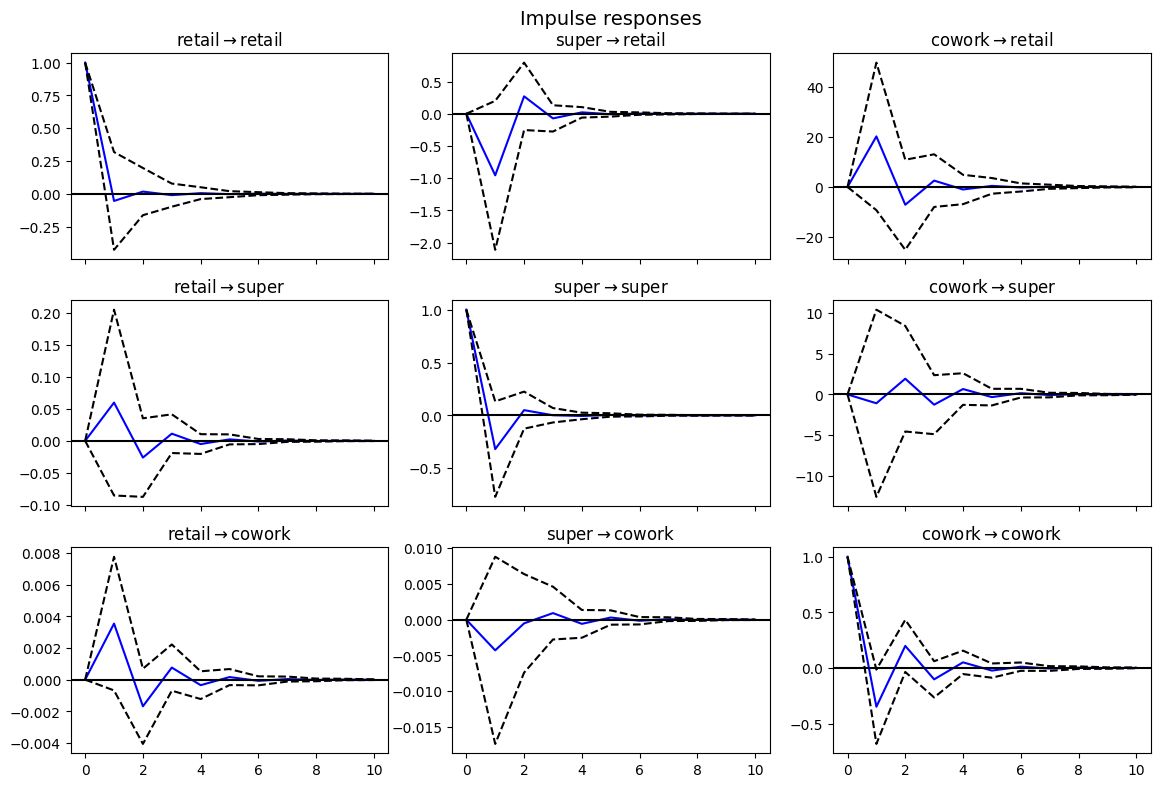

In [95]:
# Impulse response function for the model we trained
irf = results.irf(periods=10)
irf.plot(figsize=(12,8)) #Impulse response function plot
plt.show()


In [100]:
fevd = results.fevd(5)

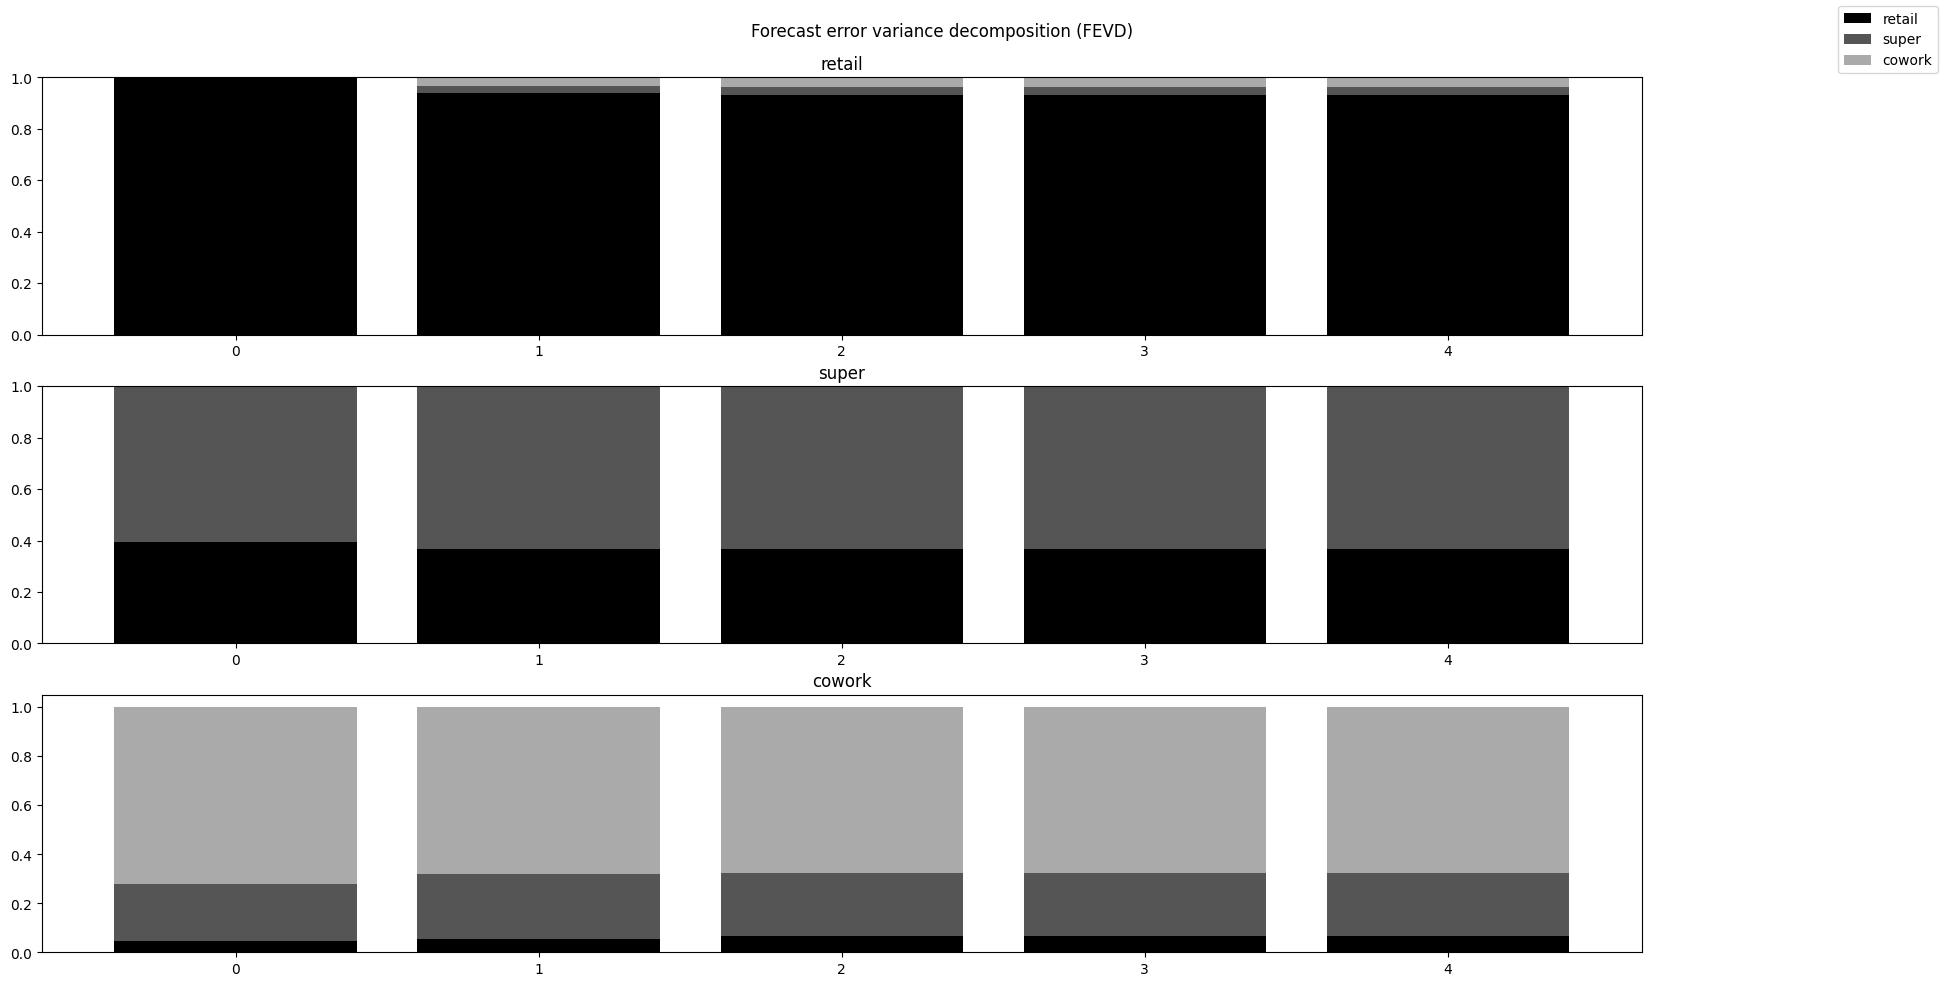

In [101]:
fevd.plot(figsize=(20,10)) #Impulse response function plot
plt.show()

In [102]:
fevd.summary()

FEVD for retail
       retail     super    cowork
0    1.000000  0.000000  0.000000
1    0.937493  0.028892  0.033615
2    0.932321  0.030267  0.037412
3    0.931806  0.030295  0.037899
4    0.931732  0.030292  0.037976

FEVD for super
       retail     super    cowork
0    0.392984  0.607016  0.000000
1    0.368808  0.630523  0.000669
2    0.366900  0.630322  0.002777
3    0.366749  0.629586  0.003665
4    0.366737  0.629350  0.003913

FEVD for cowork
       retail     super    cowork
0    0.045308  0.232639  0.722053
1    0.055804  0.263229  0.680967
2    0.064757  0.258246  0.676997
3    0.067519  0.256156  0.676325
4    0.068212  0.255609  0.676179




In [104]:
# Get the lag order
lag_order = results.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = train2.values[-lag_order:]
forecast_input

1


array([[42242.35102047, 62984.42211795,  1229.89783942]])

In [129]:
# Forecast
n_forecast = 11
fc = results.forecast(y=forecast_input, steps=n_forecast)
df_forecast = pd.DataFrame(fc, index=test2.index[-n_forecast:], columns=test2.columns + '_1d')
df_forecast

,retail_1d,super_1d,cowork_1d
mes,,,
2022-10-01,-74595.177544,-45175.587212,-543.963933
2022-11-01,-776.751808,-15699.412024,126.121718
2022-12-01,-19387.365053,-21418.695735,26.905970
2023-01-01,-14922.080171,-20599.517657,20.223971
2023-02-01,-16081.218746,-20586.238931,34.847353
2023-03-01,-15735.675102,-20675.873403,25.580684
2023-04-01,-15856.011424,-20616.447766,30.424548
2023-05-01,-15808.380366,-20647.912583,28.052005
2023-06-01,-15828.845945,-20632.425816,29.184171


In [130]:
def invert_transformation(train_df, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = train_df.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (train_df[col].iloc[-1]-train_df[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train_df[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [131]:
df_results = invert_transformation(test2, df_forecast, second_diff=False)
df_results.loc[:, ['retail_forecast', 'super_forecast', 'cowork_forecast']]

,retail_forecast,super_forecast,cowork_forecast
mes,,,
2022-10-01,-117330.929262,26287.750511,-3865.972551
2022-11-01,-118107.681070,10588.338487,-3739.850834
2022-12-01,-137495.046123,-10830.357249,-3712.944864
2023-01-01,-152417.126294,-31429.874905,-3692.720893
2023-02-01,-168498.345040,-52016.113836,-3657.873540
2023-03-01,-184234.020142,-72691.987240,-3632.292856
2023-04-01,-200090.031566,-93308.435005,-3601.868308
2023-05-01,-215898.411932,-113956.347589,-3573.816303
2023-06-01,-231727.257876,-134588.773405,-3544.632132


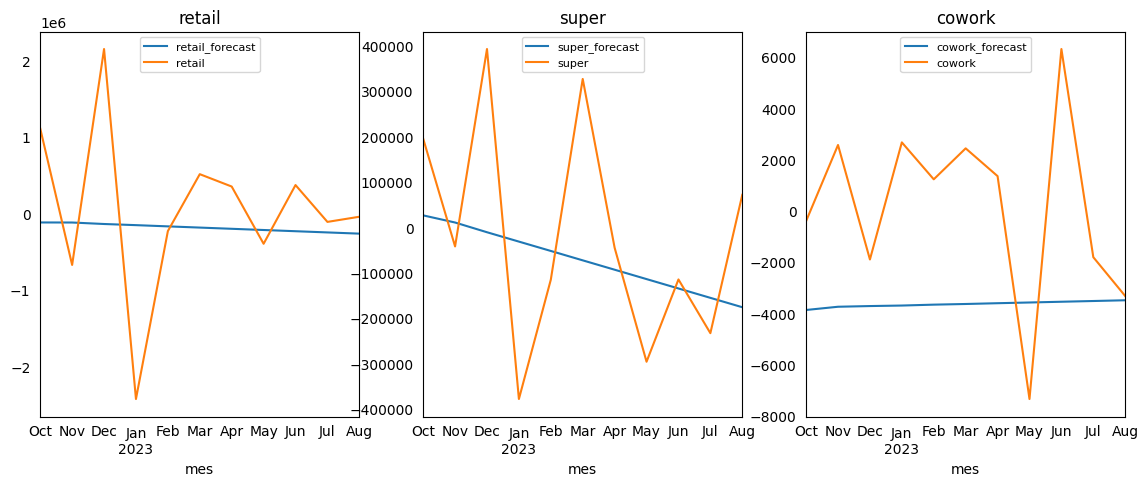

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=100, figsize=(14,5))
for i, (col,ax) in enumerate(zip(test2.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test2[col][-n_forecast:].plot(legend=True, ax=ax);
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    #ax.tick_params(labelsize=6, direction= 'out')
    ax.legend(fontsize="8",loc='upper center')
plt.show();

In [135]:
print('RETAIL')
evaluar_metricas(test2.retail, df_results['retail_forecast'])
print('================')
print('SUPER')
evaluar_metricas(test2.super, df_results['super_forecast'])
print('================')
print('COWORK')
evaluar_metricas(test2.cowork, df_results['cowork_forecast'])
print('================')

RETAIL
MSE:	1222627009247
MAE:	798996
RMSE:	1105725
MAPE:	1.420
SUPER
MSE:	52771825746
MAE:	182648
RMSE:	229721
MAPE:	1.044
COWORK
MSE:	26832502
MAE:	4487
RMSE:	5180
MAPE:	2.514


### Inciso 12 - 